### 1. Librerias

In [1]:
import pandas as pd
import numpy as np

In [2]:
#pip install optbinning
#pip install mlxtend

### 2. Carga de datos

In [3]:
ruta = 'C:/Users/Daniel/Documents/proyectos/riesgos/one year pd/chap2oneypd.csv'

In [4]:
df = pd.read_csv(ruta)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25906 entries, 0 to 25905
Data columns (total 44 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   id                             25906 non-null  int64  
 1   vintage_year                   25906 non-null  int64  
 2   monthly_installment            25906 non-null  float64
 3   loan_balance                   25906 non-null  float64
 4   bureau_score                   25473 non-null  float64
 5   num_bankrupt_iva               25473 non-null  float64
 6   time_since_bankrupt            25473 non-null  float64
 7   num_ccj                        25473 non-null  float64
 8   time_since_ccj                 25473 non-null  float64
 9   ccj_amount                     25473 non-null  float64
 10  num_bankrupt                   25473 non-null  float64
 11  num_iva                        25473 non-null  float64
 12  min_months_since_bankrupt      25473 non-null 

### 3. Limpieza y tratamiento de datos

In [6]:
df['max_arrears_12m'] = df['max_arrears_12m'].round(4)
df['arrears_months'] = df['arrears_months'].round(4)

In [7]:
# armar una función con lambda para que haga el cambio en todas las columnas que tengan 'date' en su nombre
from datetime import datetime
df['origination_date2'] = pd.to_datetime(df['origination_date'])
df['origination_date2'] = df['origination_date2'].dt.strftime('%Y-%m-%d')

df['maturity_date2'] = pd.to_datetime(df['maturity_date'])
df['maturity_date2'] = df['maturity_date2'].dt.strftime('%Y-%m-%d')

df['recent_arrears_date2'] = pd.to_datetime(df['recent_arrears_date'])
df['recent_arrears_date2'] = df['recent_arrears_date2'].dt.strftime('%Y-%m-%d')

C:\Users\Daniel\AppData\Local\Temp\ipykernel_21244\2291711405.py:3: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df['origination_date2'] = pd.to_datetime(df['origination_date'])
C:\Users\Daniel\AppData\Local\Temp\ipykernel_21244\2291711405.py:6: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df['maturity_date2'] = pd.to_datetime(df['maturity_date'])
C:\Users\Daniel\AppData\Local\Temp\ipykernel_21244\2291711405.py:9: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df['recent_arrears_date2'] = pd.to_datetime(df['recent_arrears_date'])


#### 3.1 Identificación de 'NaN'

In [8]:
# recent_arrears_date, months_since_2mia tienen un alto porcentaje de 'nan' por lo tanto no se consideran 
# eliminación de los registros con nan de la variables bureau_score,num_bankrupt_iva,time_since_bankrupt,num_ccj,time_since_ccj,ccj_amount,num_bankrupt
# num_iva,min_months_since_bankrupt

df.isna().sum().to_frame()


,0
id,0
vintage_year,0
monthly_installment,0
loan_balance,0
bureau_score,433
num_bankrupt_iva,433
time_since_bankrupt,433
num_ccj,433
time_since_ccj,433
ccj_amount,433


In [9]:
# recent_arrears_date, months_since_2mia tienen un alto porcentaje de 'nan' por lo tanto no se consideran dentro del análisis
df2 = df.drop(['recent_arrears_date','months_since_2mia','recent_arrears_date2'],axis=1)

In [10]:
# eliminación los registros con 'nan' de la variables bureau_score,num_bankrupt_iva,time_since_bankrupt,num_ccj,time_since_ccj,ccj_amount,num_bankrupt
# num_iva,min_months_since_bankrupt
df2 = df2[(df2.bureau_score.notna())].reset_index(drop=True)

In [11]:
# eliminación los registros con 'nan' de la variable avg_mia_6m,max_arrears_bal_6m,max_mia_6m,avg_bal_6m,avg_bureau_score_6m 
df2 = df2[(df2.avg_bureau_score_6m.notna())].reset_index(drop=True)

In [12]:
# eliminación los registros con 'nan' de la variable region
df2 = df2[(df2.region.notna())].reset_index(drop=True)

In [13]:
# validación de la no exitencia de atributos 'NaN' dentro del dataframe
df2.isna().sum().to_frame()

,0
id,0
vintage_year,0
monthly_installment,0
loan_balance,0
bureau_score,0
num_bankrupt_iva,0
time_since_bankrupt,0
num_ccj,0
time_since_ccj,0
ccj_amount,0


#### 3.1 Contrucción de marca de default (tgt) 

In [14]:
df2['default_event'] = np.where((df2.arrears_event == 1) | (df2.bankrupt_event == 1) | (df2.term_expiry_event == 1),1,0)

In [15]:
df2.default_event.value_counts(normalize = True)*100
# con dataframe df quitando registros con 'nan'
# %no evento 0 = 94.742531 
# %evento 1 = 5.257469
# nos damos cuenta que el dataframe se sncuentr desbalanceda en la variable objetivo (evento y no evento)

default_event
0    94.753583
1     5.246417
Name: proportion, dtype: float64

In [16]:
# unidad muestral
um   = ['id']
# target, marca de incumplimiento
tgt = ['default_event']

# varibles continuas
var_con= ['monthly_installment','loan_balance','bureau_score','time_since_bankrupt','time_since_ccj',
        'ccj_amount','min_months_since_bankrupt','ltv','arrears_months'
        ,'mob','remaining_mat','loan_term','max_arrears_12m','max_arrears_bal_6m','avg_bal_6m','avg_bureau_score_6m',
        'cc_util','annual_income','months_since_recent_cc_delinq'
        ]

# variables categoricas
var_cat = ['num_bankrupt_iva','num_ccj','num_bankrupt','num_iva','pl_flag','region','repayment_type','arrears_status','arrears_segment',
           'live_status','repaid_status','month','arrears_event','bankrupt_event','term_expiry_event','worst_arrears_status','avg_mia_6m',
           'max_mia_6m','emp_length']

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns

porcentaje de tgt:  5.246416650304339
porcentaje de no tgt:  94.75358334969566


Text(0.5, 1.0, 'conteo de casos de fraude')

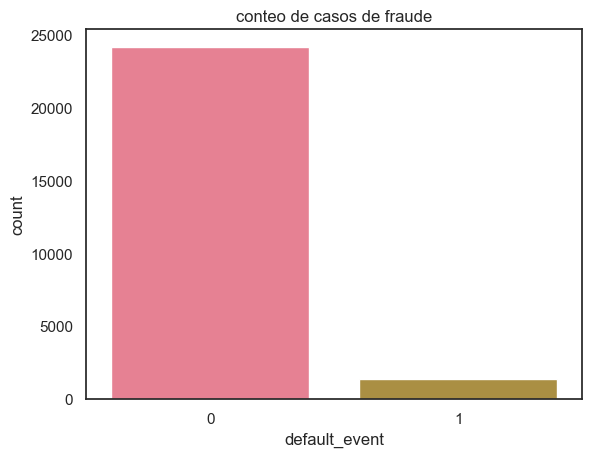

In [18]:
# cases of default and non default
print('porcentaje de tgt: ',df2[tgt].value_counts()[1] /df2.shape[0] * 100)
print('porcentaje de no tgt: ',df2[tgt].value_counts()[0] /df2.shape[0] * 100)
sns.set_theme(style = 'white',palette = 'husl')
ax = sns.countplot(x = 'default_event' , data = df2)
ax.set_title('conteo de casos de fraude')

Text(0.5, 1.0, 'Cases of default and non default according with num_ccj')

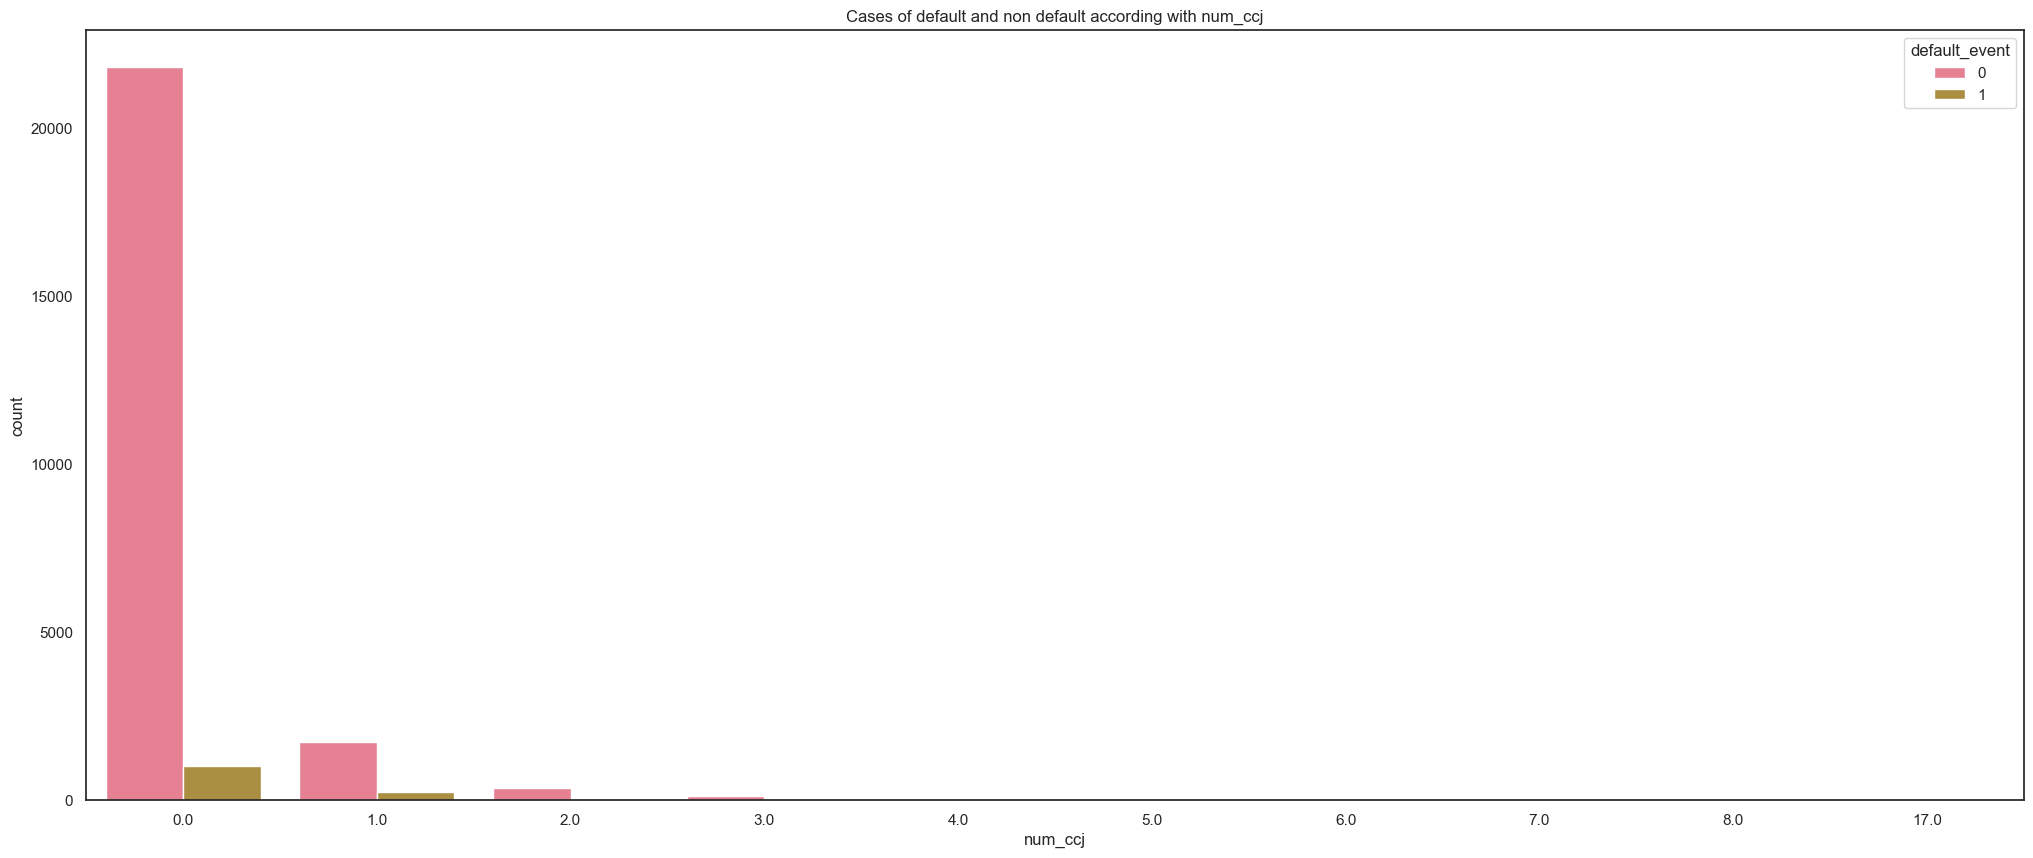

In [19]:
# Cases of default and non default , variable num_ccj
plt.figure(1,figsize = (25,10))
sns.countplot(hue = df2.default_event, x = df2.num_ccj)
plt.title('Cases of default and non default according with num_ccj')

Text(0.5, 1.0, 'Cases of default and non default according with num_bankrupt')

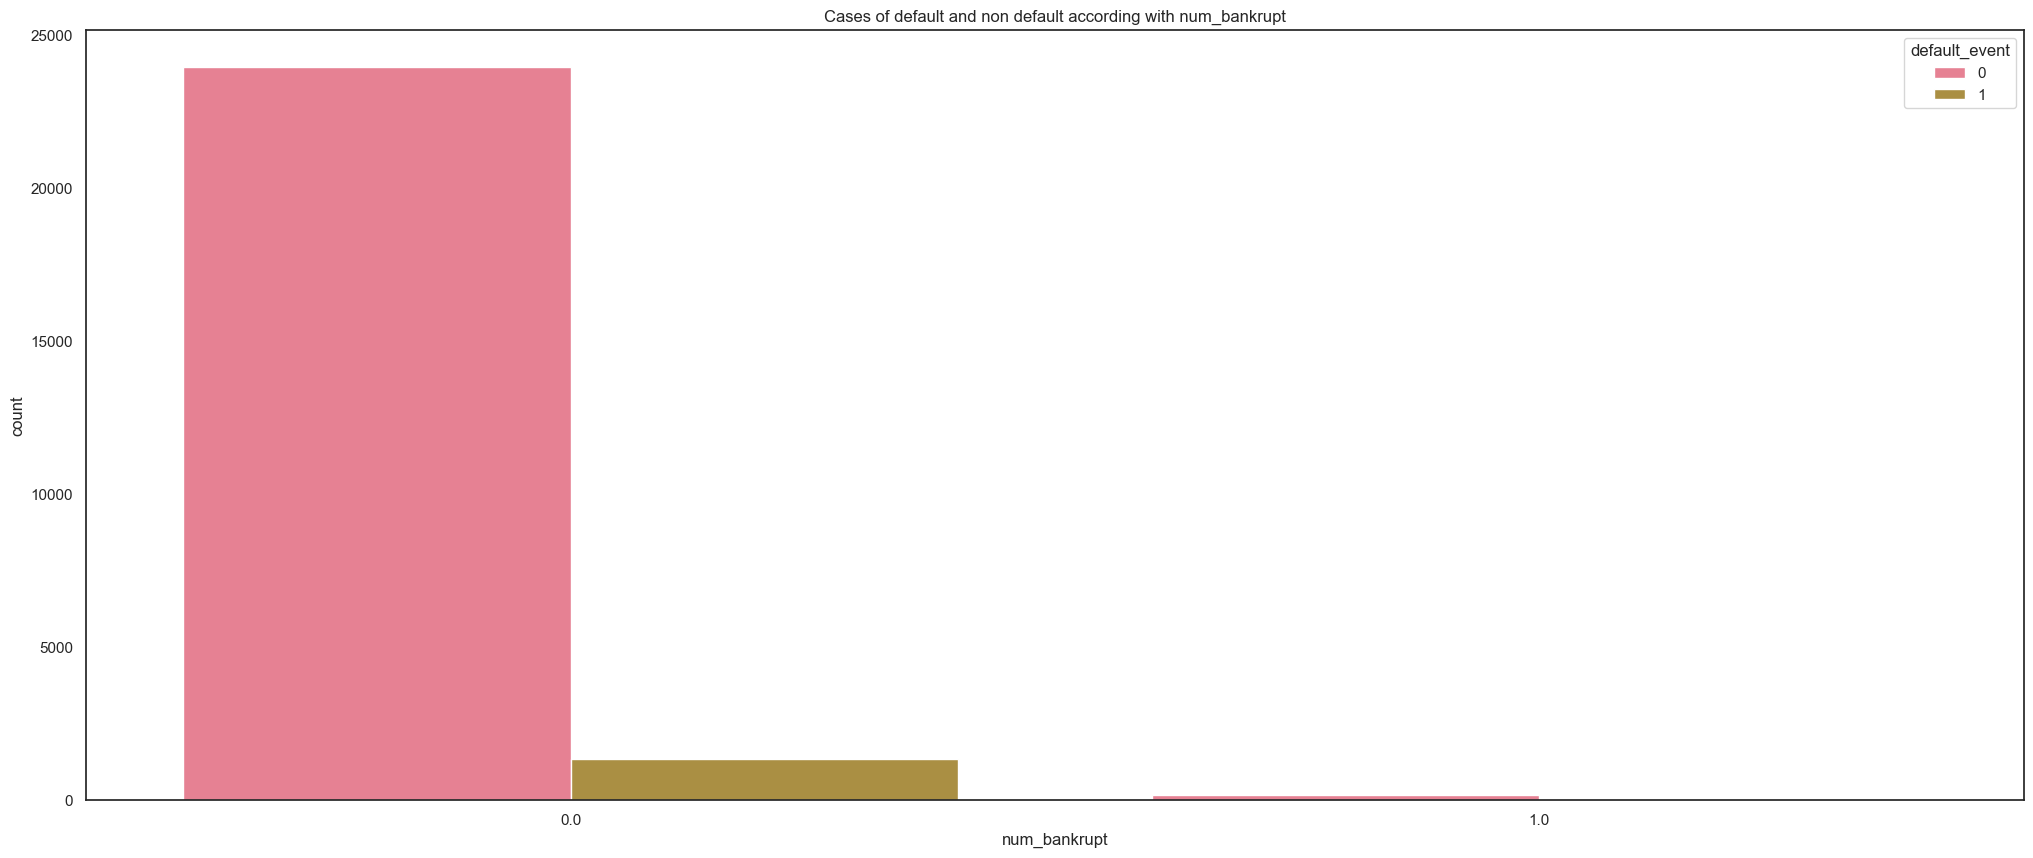

In [20]:
# Cases of default and non default , variable num_bankrupt
plt.figure(1,figsize = (25,10))
sns.countplot(hue = df2.default_event, x = df2.num_bankrupt)
plt.title('Cases of default and non default according with num_bankrupt')

Text(0.5, 1.0, 'Cases of default and non default according with num_iva')

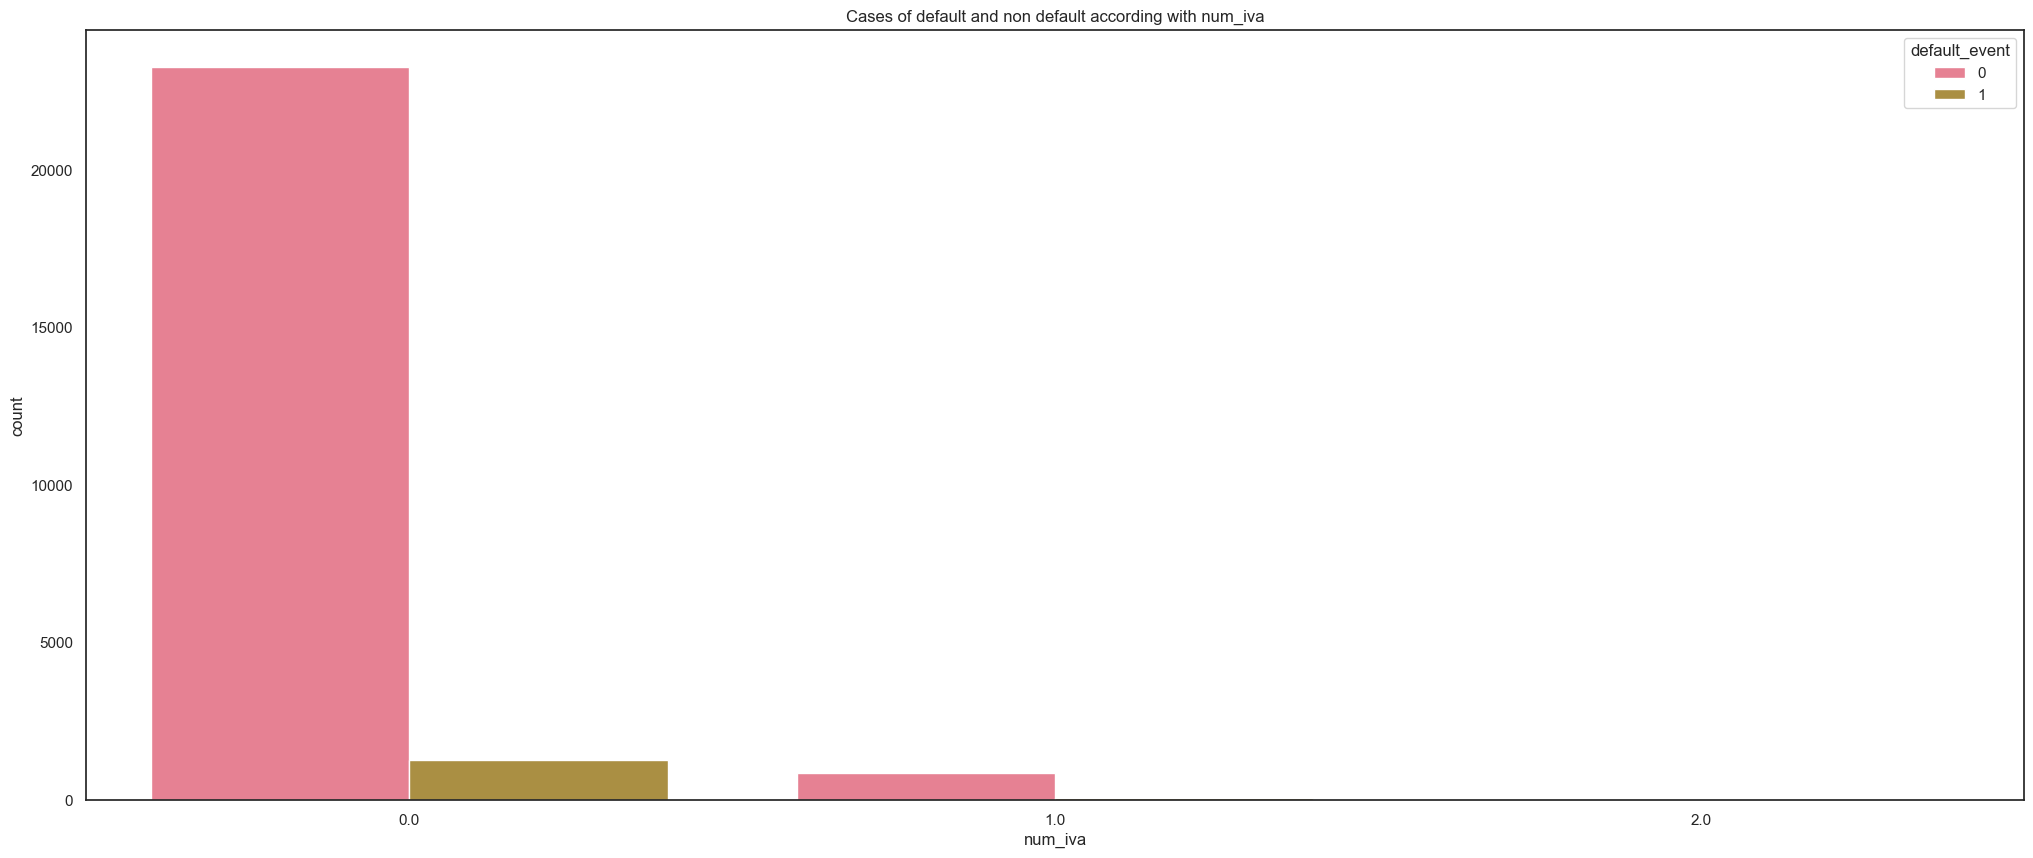

In [21]:
# Cases of default and non default , variable num_iva
plt.figure(1,figsize = (25,10))
sns.countplot(hue = df2.default_event, x = df2.num_iva)
plt.title('Cases of default and non default according with num_iva')

#'num_iva','pl_flag','region','repayment_type','arrears_status','arrears_segment',
#           'live_status','repaid_status','month','arrears_event','bankrupt_event','term_expiry_event','worst_arrears_status','avg_mia_6m',
#           'max_mia_6m','emp_length']

Text(0.5, 1.0, 'Cases of default and non default according with pl_flag')

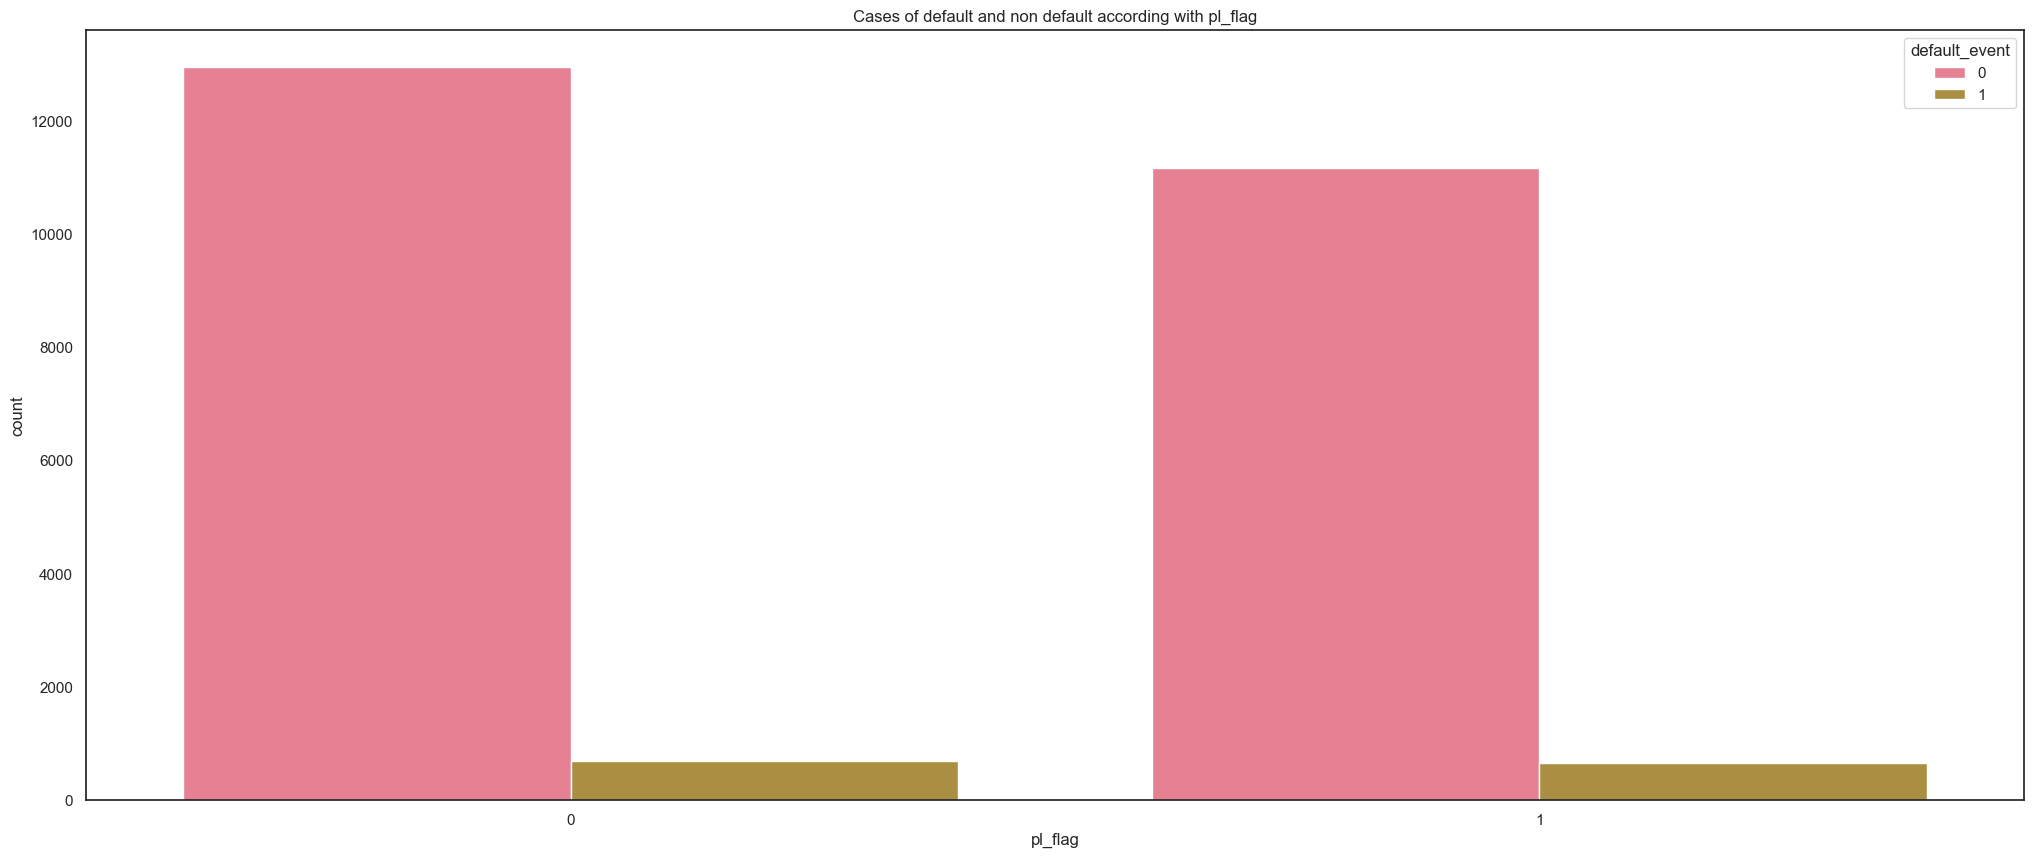

In [22]:
# Cases of default and non default , variable pl_flag
plt.figure(1,figsize = (25,10))
sns.countplot(hue = df2.default_event, x = df2.pl_flag)
plt.title('Cases of default and non default according with pl_flag')

#'num_iva','pl_flag','region','repayment_type','arrears_status','arrears_segment',
#           'live_status','repaid_status','month','arrears_event','bankrupt_event','term_expiry_event','worst_arrears_status','avg_mia_6m',
#           'max_mia_6m','emp_length']

Text(0.5, 1.0, 'Cases of default and non default according with region')

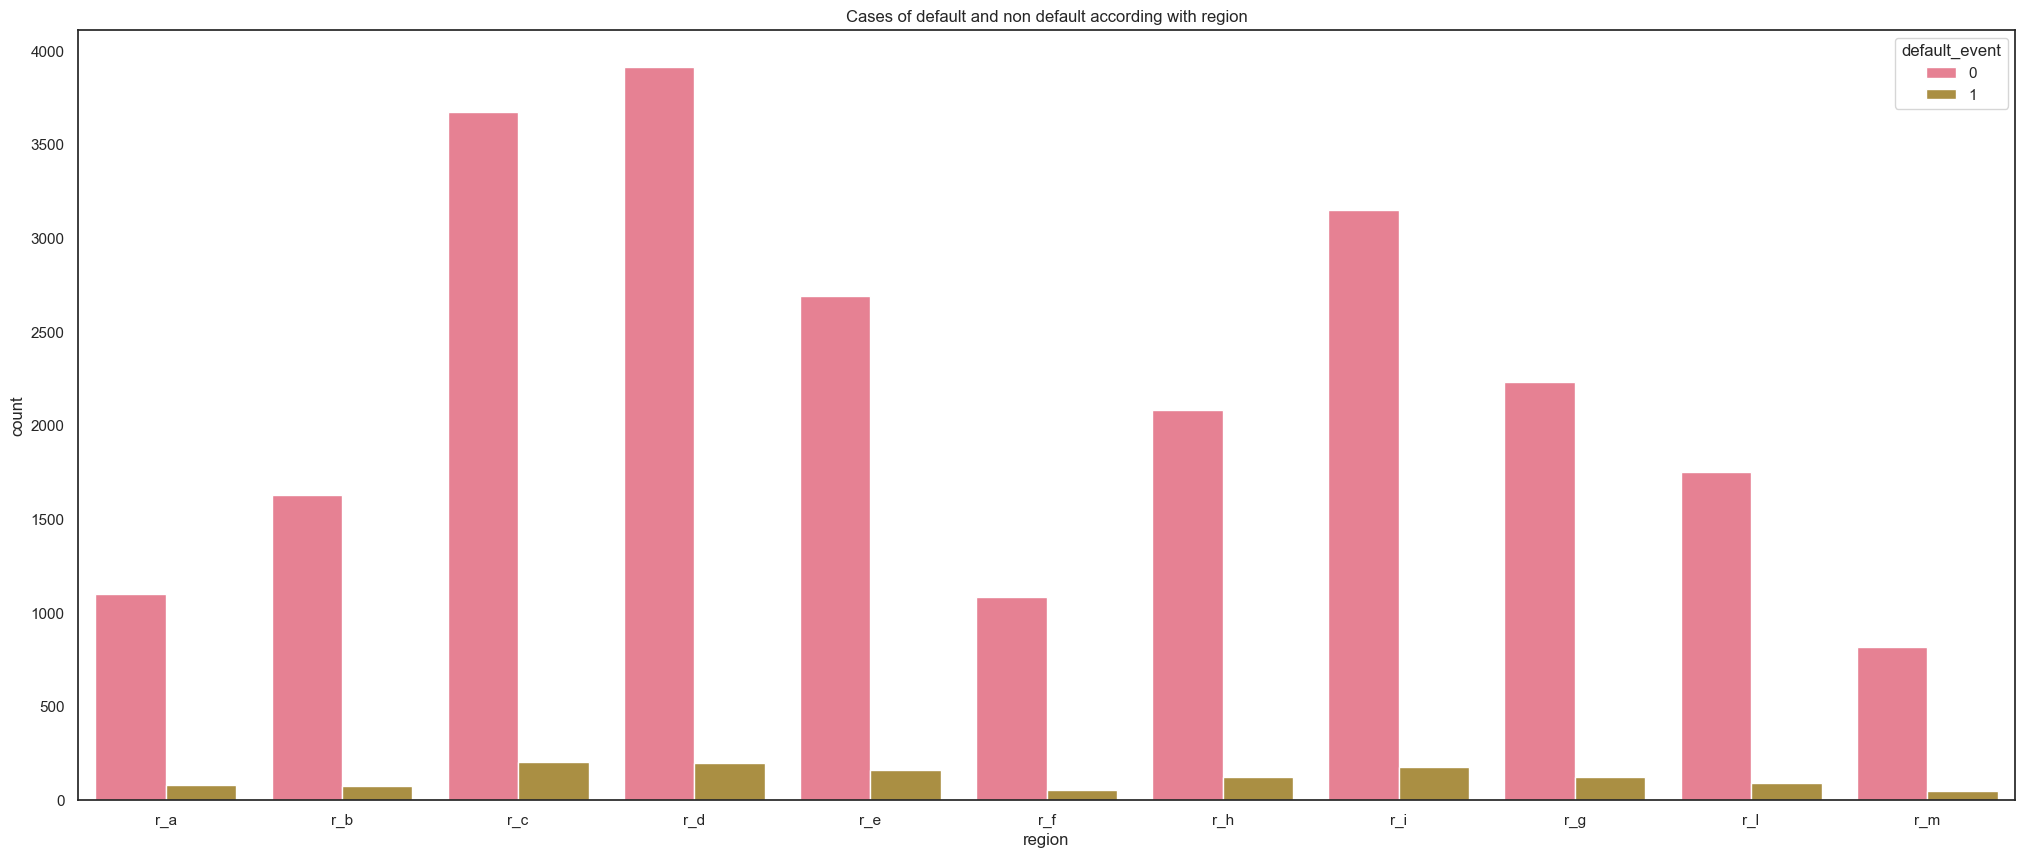

In [23]:
# Cases of default and non default , variable region
plt.figure(1,figsize = (25,10))
sns.countplot(hue = df2.default_event, x = df2.region)
plt.title('Cases of default and non default according with region')

## ok pl_flag, region

#'num_iva','pl_flag','region','repayment_type','arrears_status','arrears_segment',
#           'live_status','repaid_status','month','arrears_event','bankrupt_event','term_expiry_event','worst_arrears_status','avg_mia_6m',
#           'max_mia_6m','emp_length']

Text(0.5, 1.0, 'Cases of default and non default according with repayment_type')

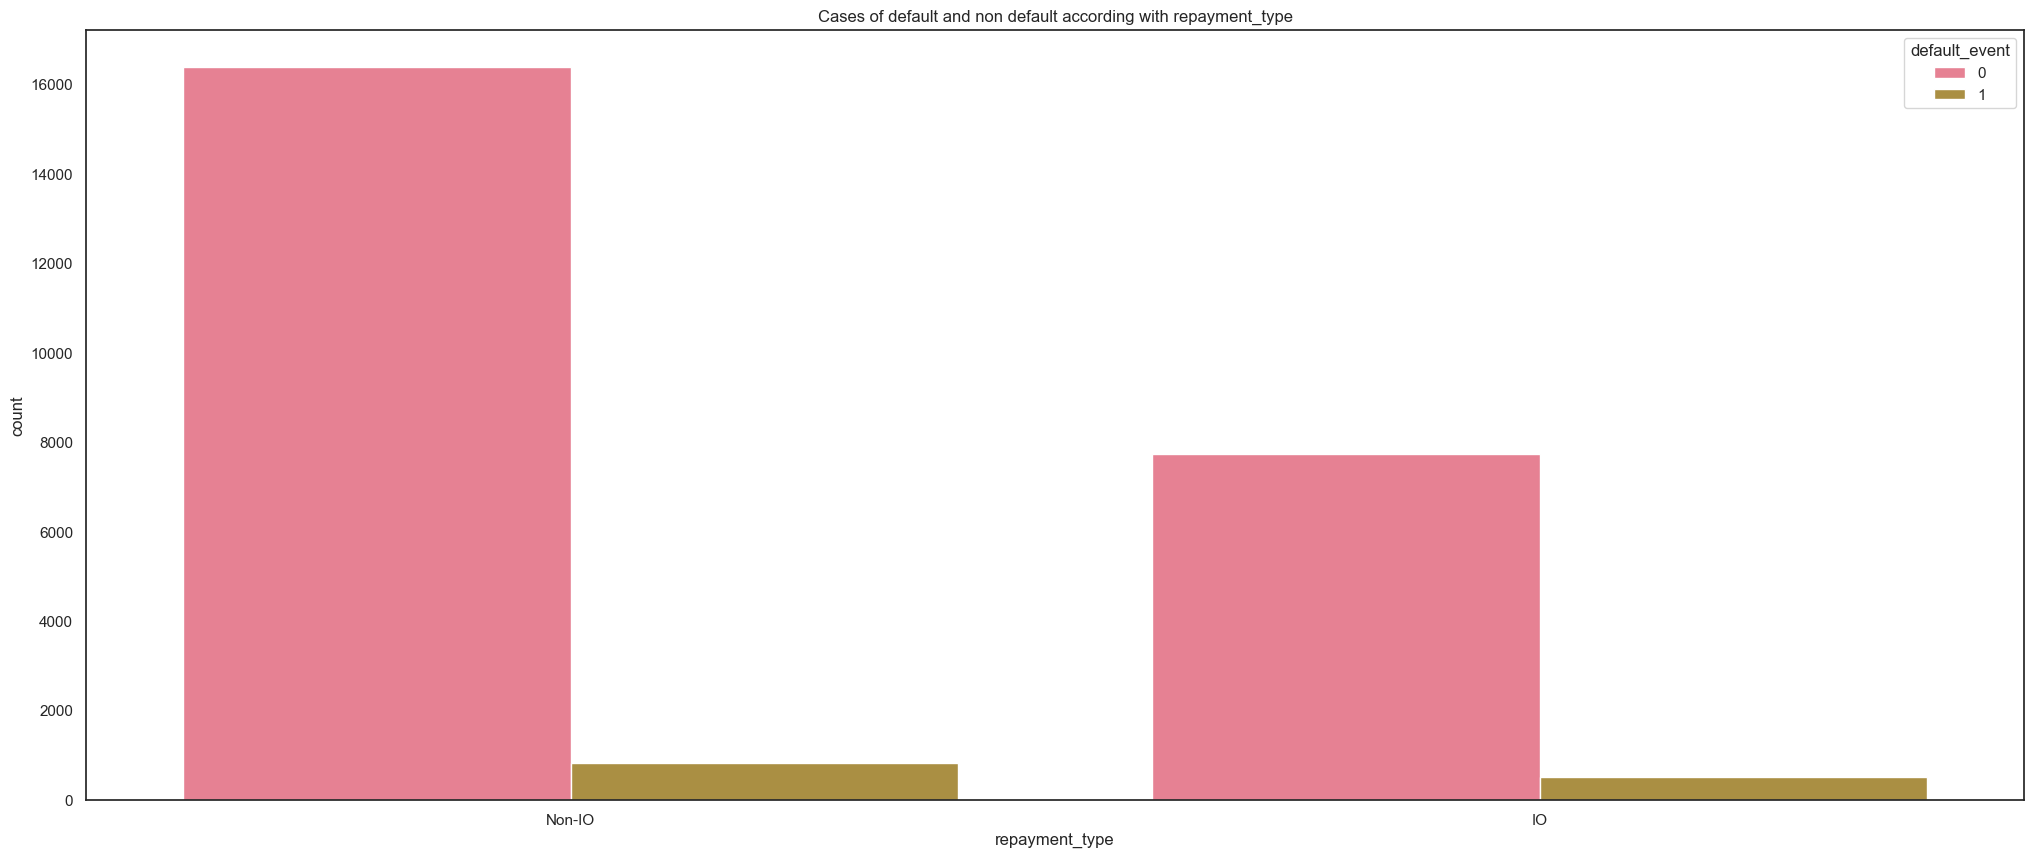

In [24]:
# Cases of default and non default , variable repayment_type
plt.figure(1,figsize = (25,10))
sns.countplot(hue = df2.default_event, x = df2.repayment_type)
plt.title('Cases of default and non default according with repayment_type')

## ok pl_flag, region, repayment_type

#'num_iva','pl_flag','region','repayment_type','arrears_status','arrears_segment',
#           'live_status','repaid_status','month','arrears_event','bankrupt_event','term_expiry_event','worst_arrears_status','avg_mia_6m',
#           'max_mia_6m','emp_length']

Text(0.5, 1.0, 'Cases of default and non default according with arrears_status')

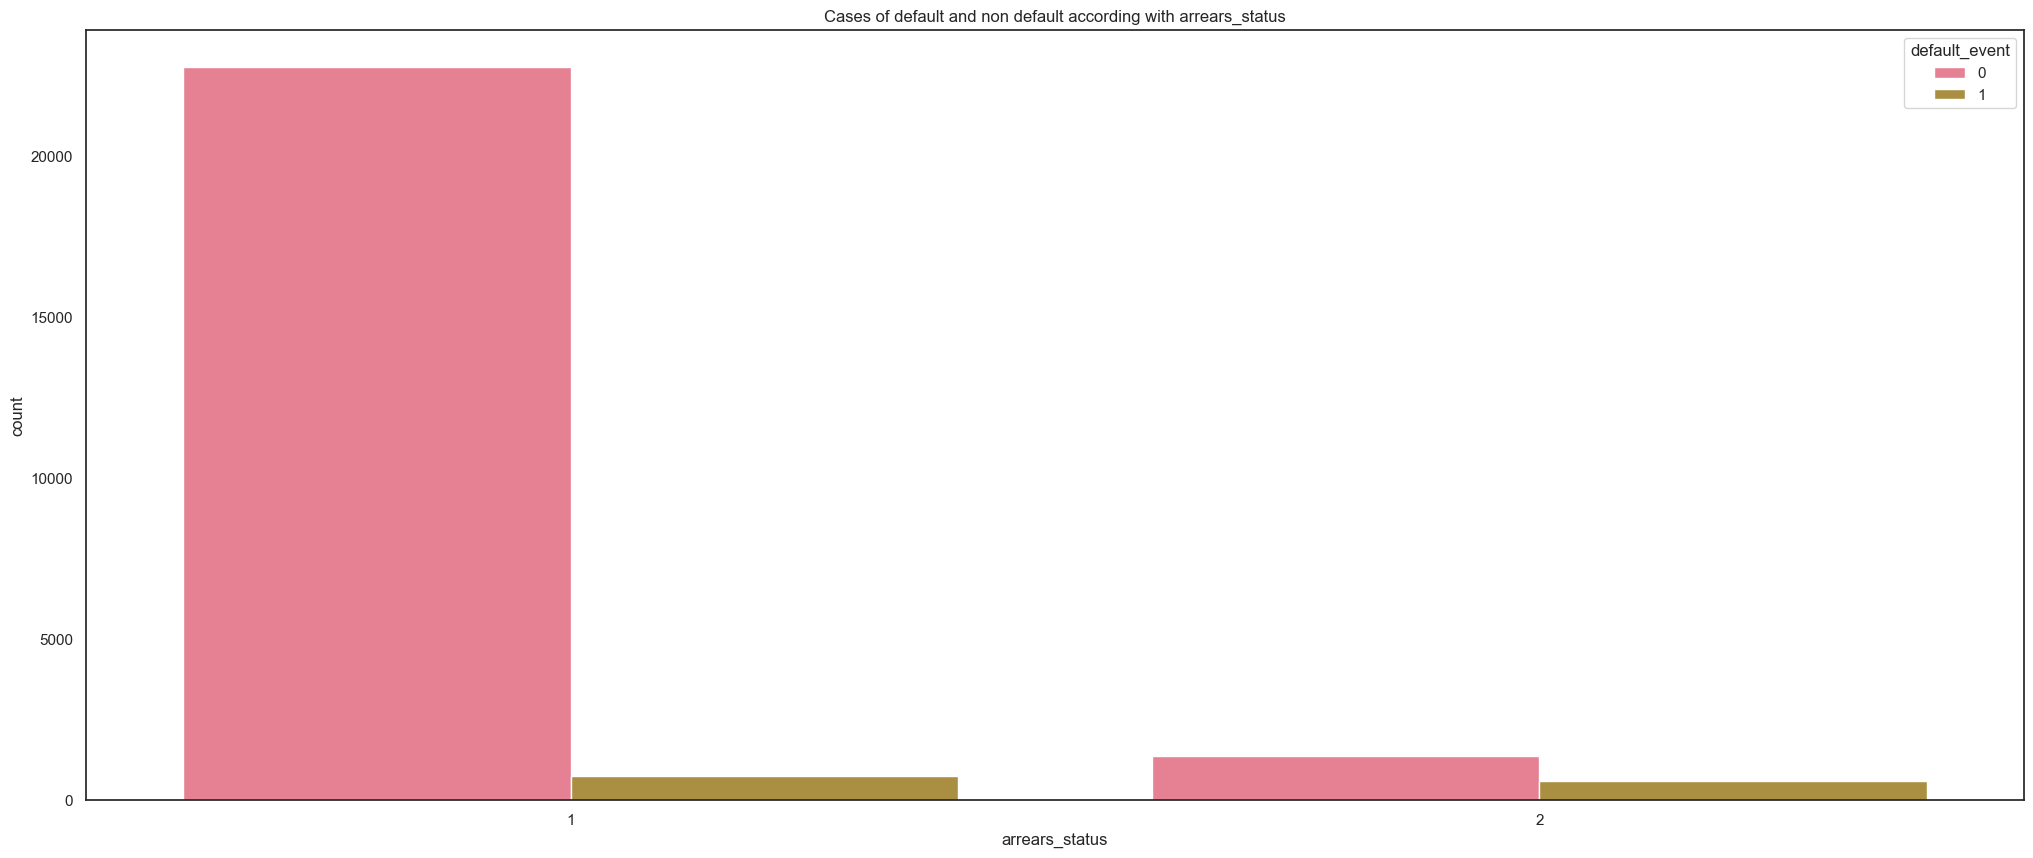

In [25]:
# Cases of default and non default , variable arrears_status
plt.figure(1,figsize = (25,10))
sns.countplot(hue = df2.default_event, x = df2.arrears_status)
plt.title('Cases of default and non default according with arrears_status')

## ok pl_flag, region, repayment_type

#'num_iva','pl_flag','region','repayment_type','arrears_status','arrears_segment',
#           'live_status','repaid_status','month','arrears_event','bankrupt_event','term_expiry_event','worst_arrears_status','avg_mia_6m',
#           'max_mia_6m','emp_length']

Text(0.5, 1.0, 'Cases of default and non default according with arrears_segment')

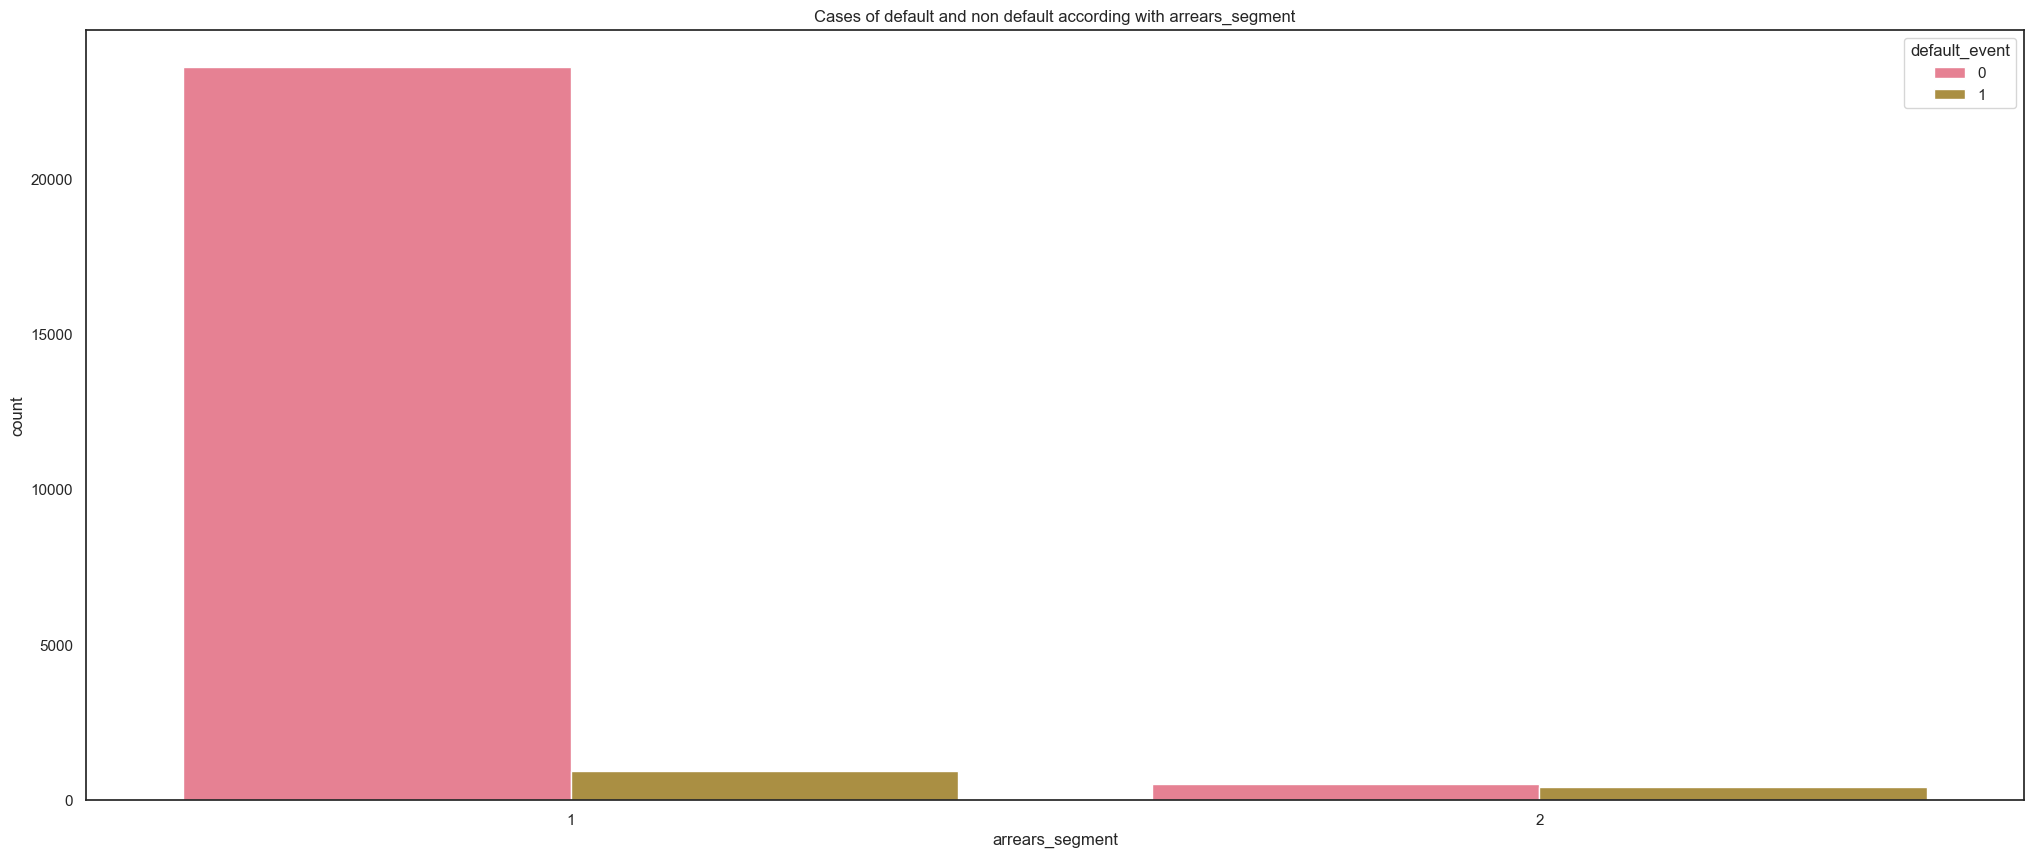

In [26]:
# Cases of default and non default , variable arrears_segment
plt.figure(1,figsize = (25,10))
sns.countplot(hue = df2.default_event, x = df2.arrears_segment)
plt.title('Cases of default and non default according with arrears_segment')

## ok pl_flag, region, repayment_type

#'num_iva','pl_flag','region','repayment_type','arrears_status','arrears_segment',
#           'live_status','repaid_status','month','arrears_event','bankrupt_event','term_expiry_event','worst_arrears_status','avg_mia_6m',
#           'max_mia_6m','emp_length']

Text(0.5, 1.0, 'Cases of default and non default according with live_status')

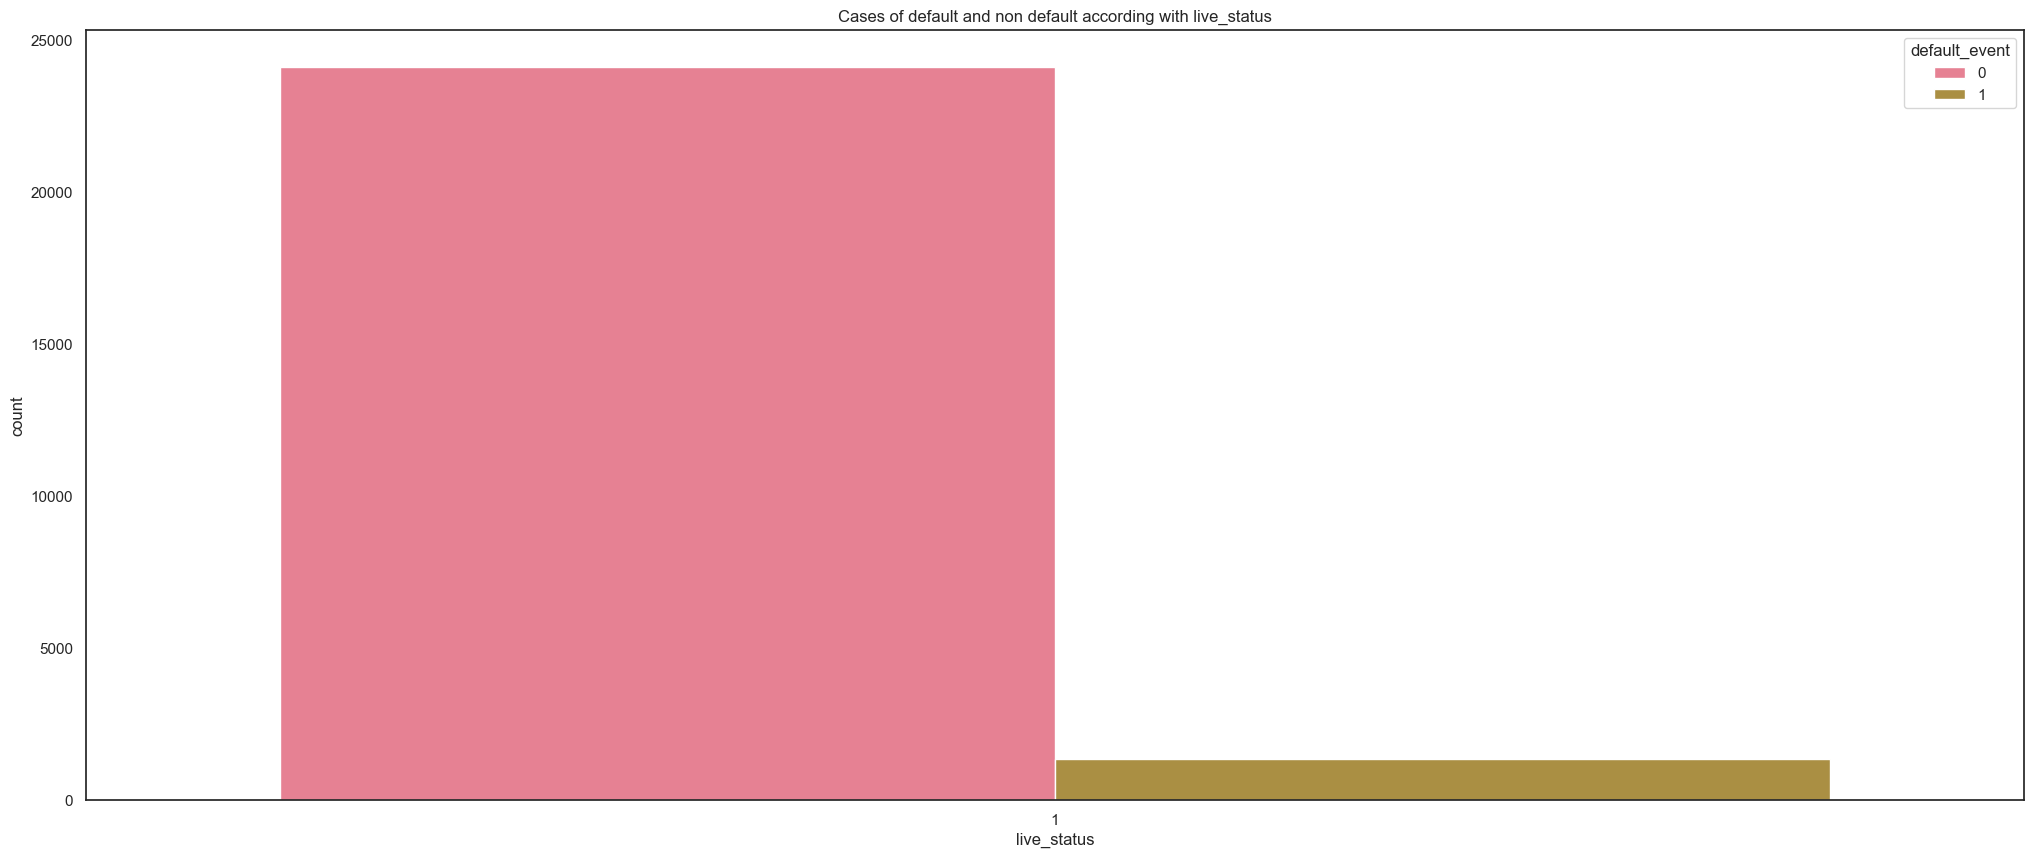

In [27]:
# Cases of default and non default , variable live_status
plt.figure(1,figsize = (25,10))
sns.countplot(hue = df2.default_event, x = df2.live_status)
plt.title('Cases of default and non default according with live_status')

## ok pl_flag, region, repayment_type

#'num_iva','pl_flag','region','repayment_type','arrears_status','arrears_segment',
#           'live_status','repaid_status','month','arrears_event','bankrupt_event','term_expiry_event','worst_arrears_status','avg_mia_6m',
#           'max_mia_6m','emp_length']

Text(0.5, 1.0, 'Cases of default and non default according with repaid_status')

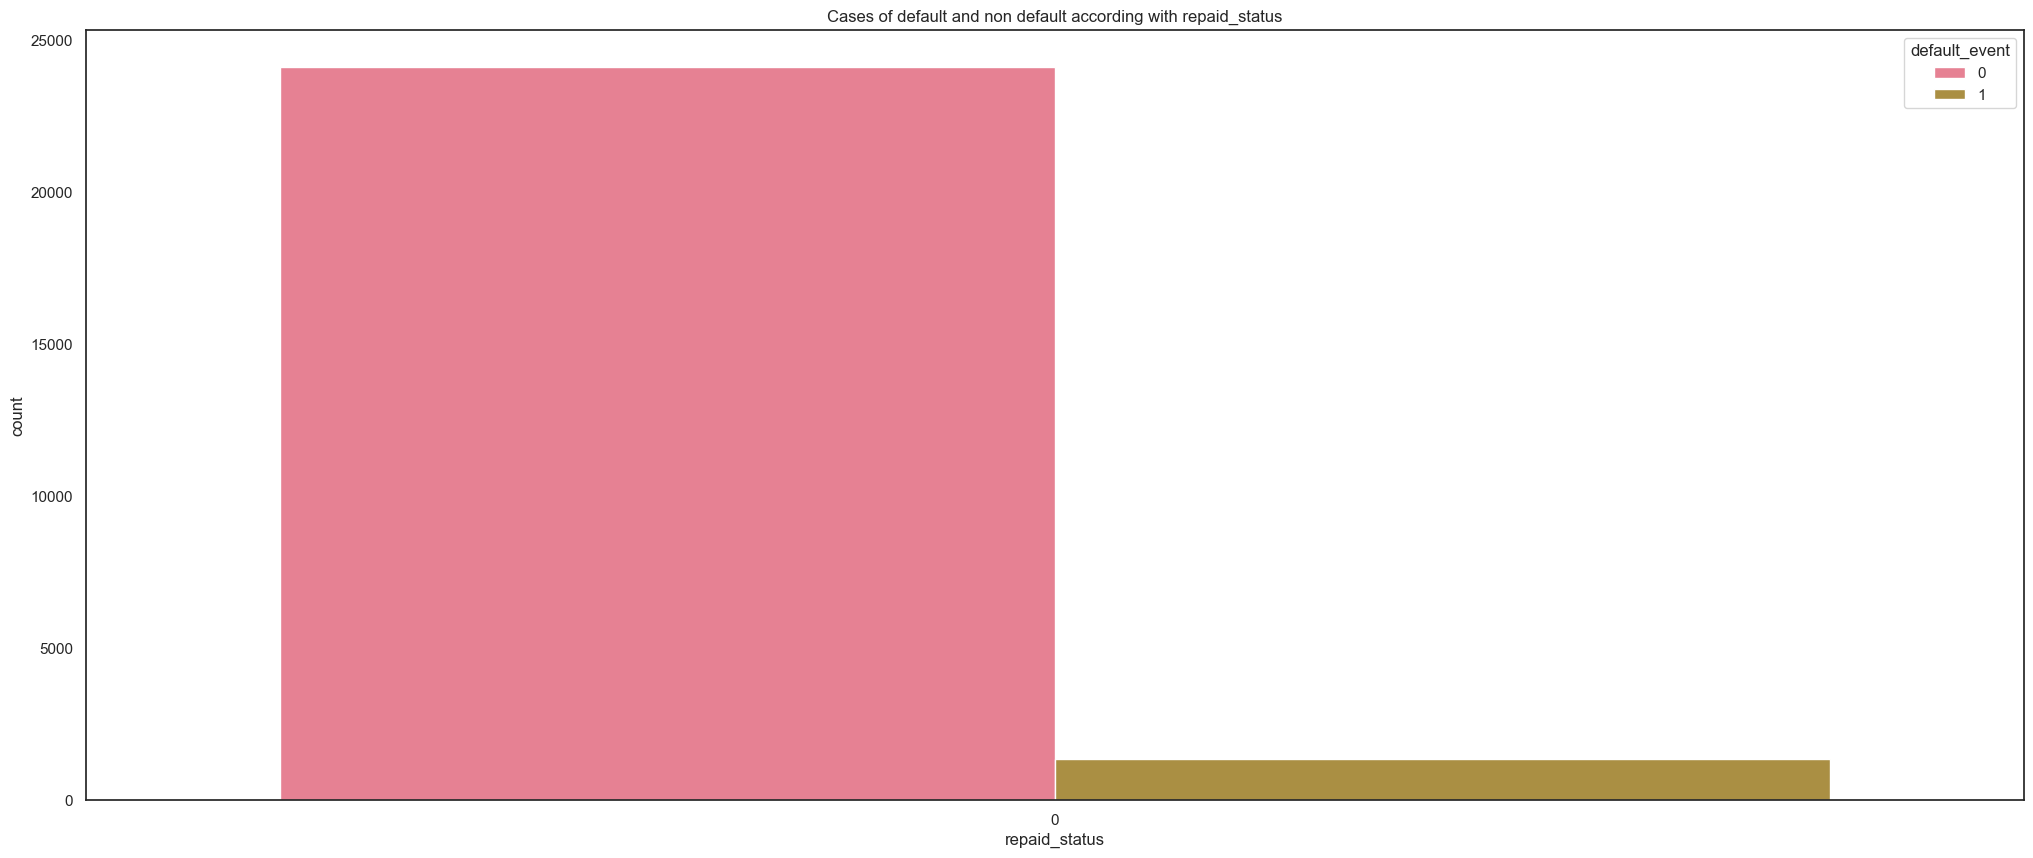

In [28]:
# Cases of default and non default , variable repaid_status
plt.figure(1,figsize = (25,10))
sns.countplot(hue = df2.default_event, x = df2.repaid_status)
plt.title('Cases of default and non default according with repaid_status')

## ok pl_flag, region, repayment_type

#'num_iva','pl_flag','region','repayment_type','arrears_status','arrears_segment',
#           'live_status','repaid_status','month','arrears_event','bankrupt_event','term_expiry_event','worst_arrears_status','avg_mia_6m',
#           'max_mia_6m','emp_length']

Text(0.5, 1.0, 'Cases of default and non default according with month')

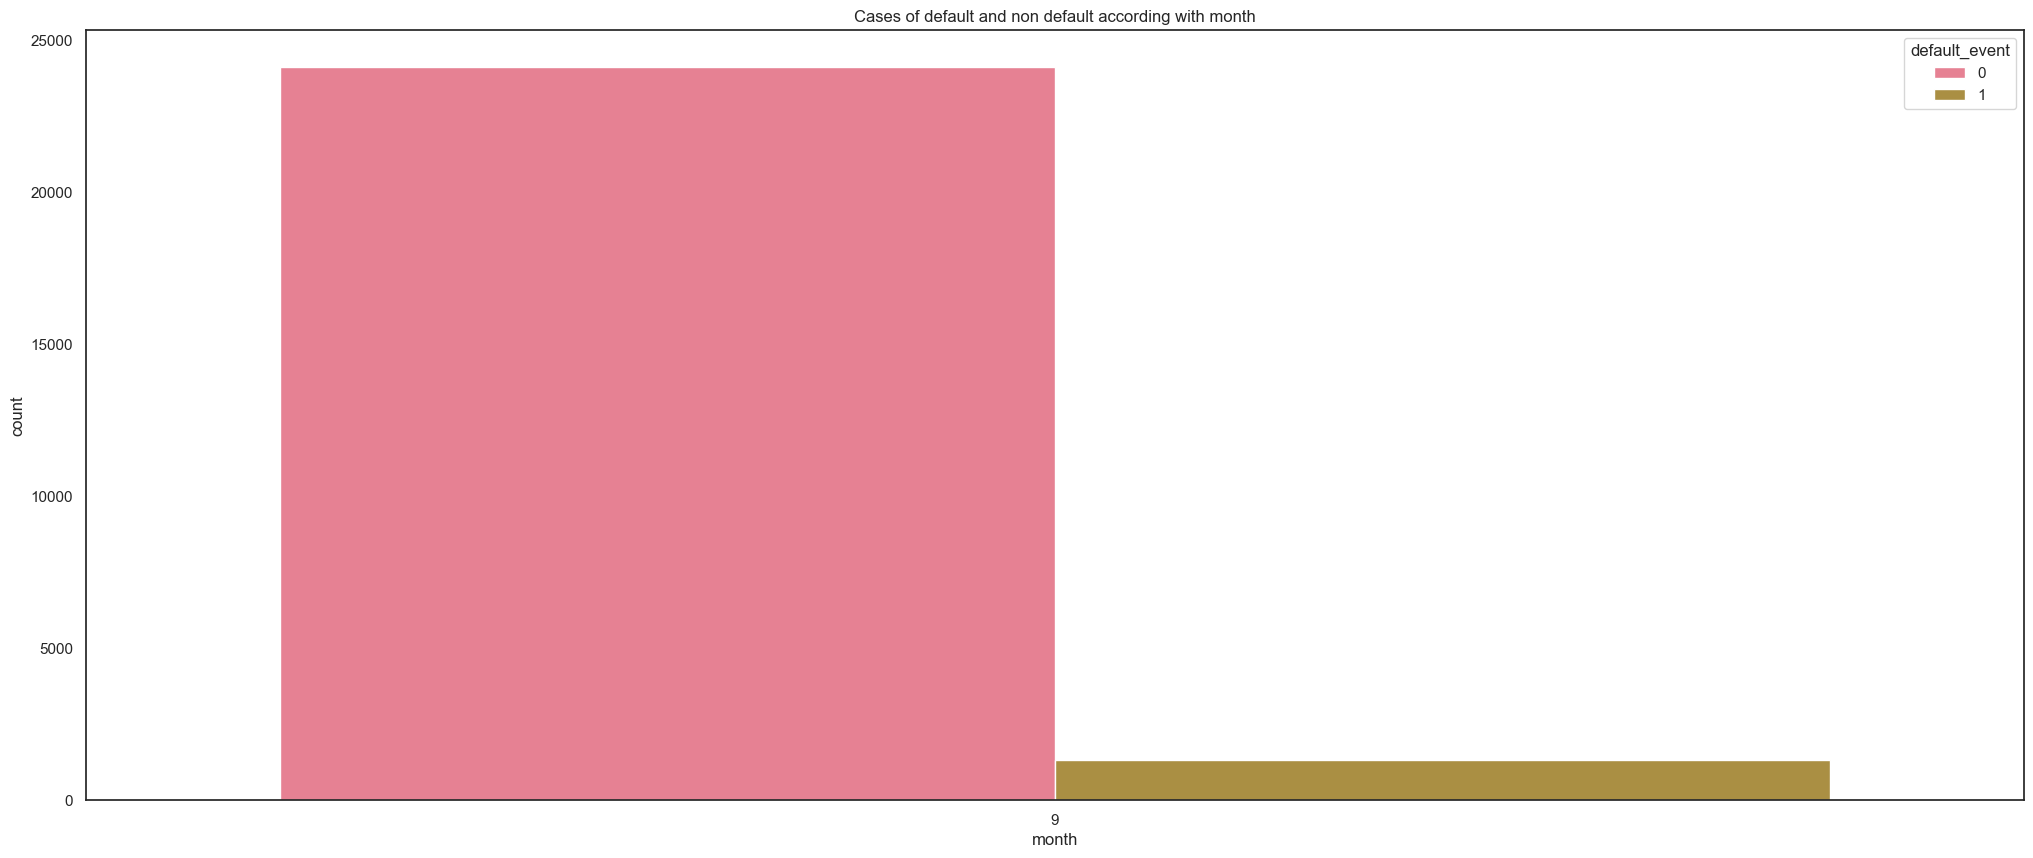

In [29]:
# Cases of default and non default , variable month
plt.figure(1,figsize = (25,10))
sns.countplot(hue = df2.default_event, x = df2.month)
plt.title('Cases of default and non default according with month')

## ok pl_flag, region, repayment_type

#'num_iva','pl_flag','region','repayment_type','arrears_status','arrears_segment',
#           'live_status','repaid_status','month','arrears_event','bankrupt_event','term_expiry_event','worst_arrears_status','avg_mia_6m',
#           'max_mia_6m','emp_length']

Text(0.5, 1.0, 'Cases of default and non default according with arrears_event')

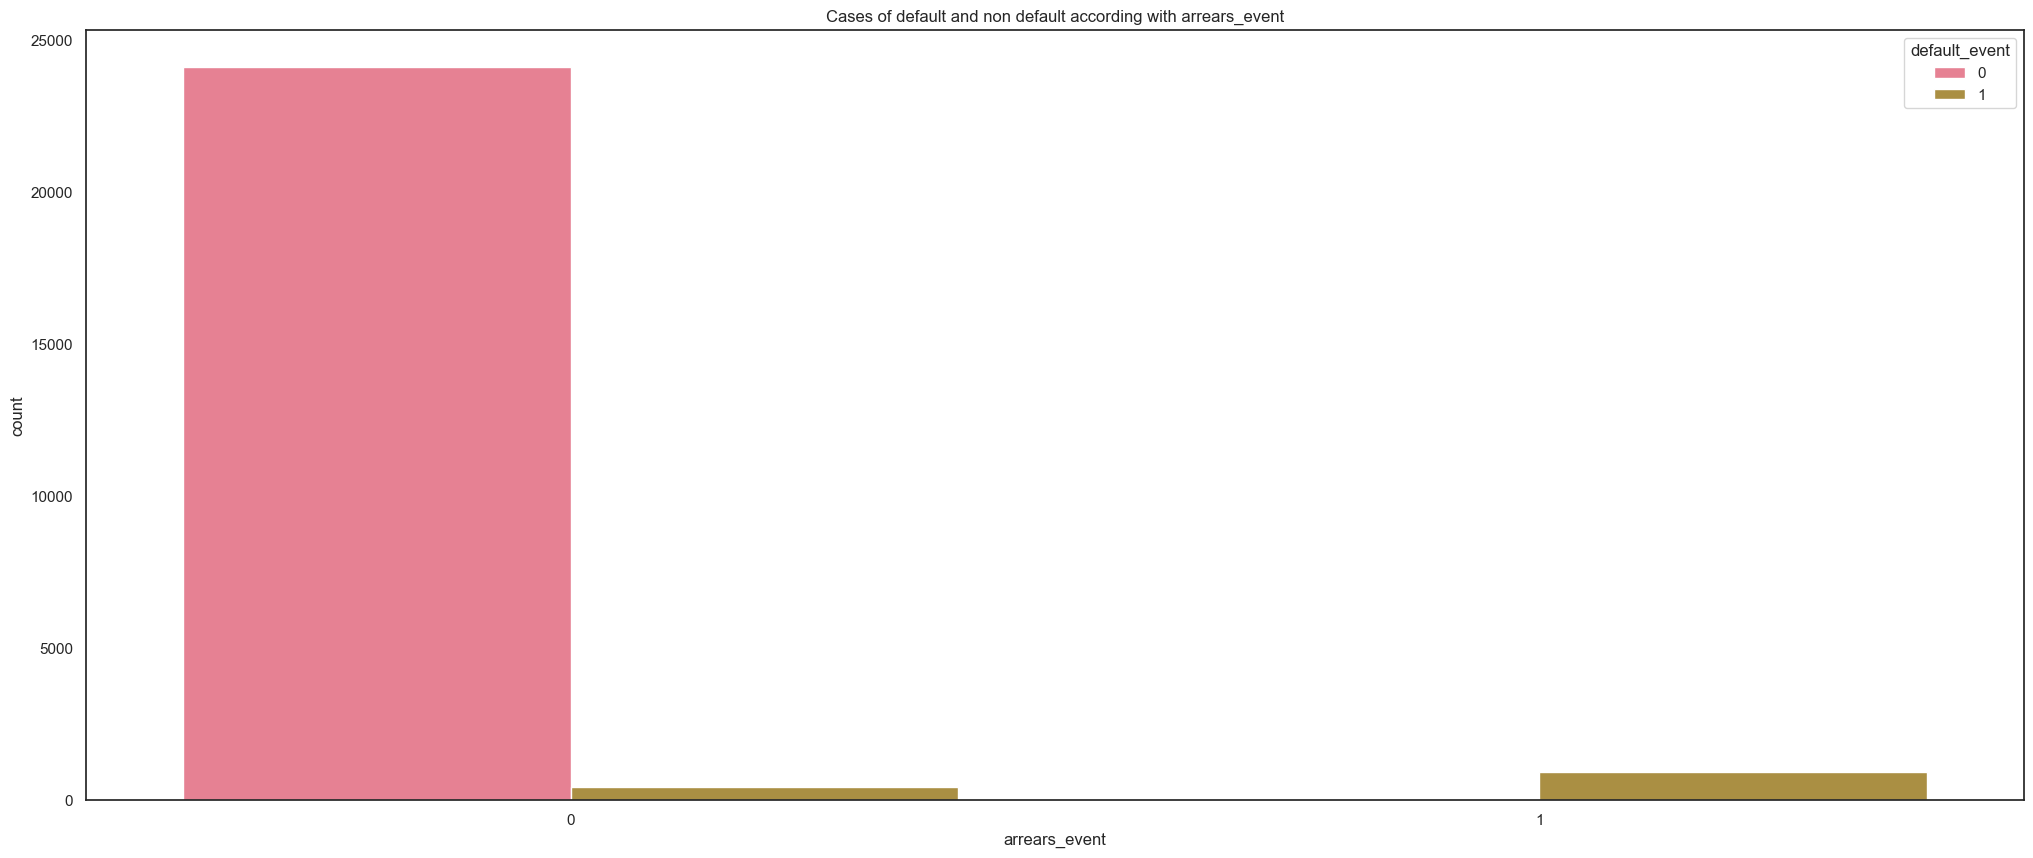

In [30]:
# Cases of default and non default , variable arrears_event
plt.figure(1,figsize = (25,10))
sns.countplot(hue = df2.default_event, x = df2.arrears_event)
plt.title('Cases of default and non default according with arrears_event')

## ok pl_flag, region, repayment_type

#'num_iva','pl_flag','region','repayment_type','arrears_status','arrears_segment',
#           'live_status','repaid_status','month','arrears_event','bankrupt_event','term_expiry_event','worst_arrears_status','avg_mia_6m',
#           'max_mia_6m','emp_length']

Text(0.5, 1.0, 'Cases of default and non default according with bankrupt_event')

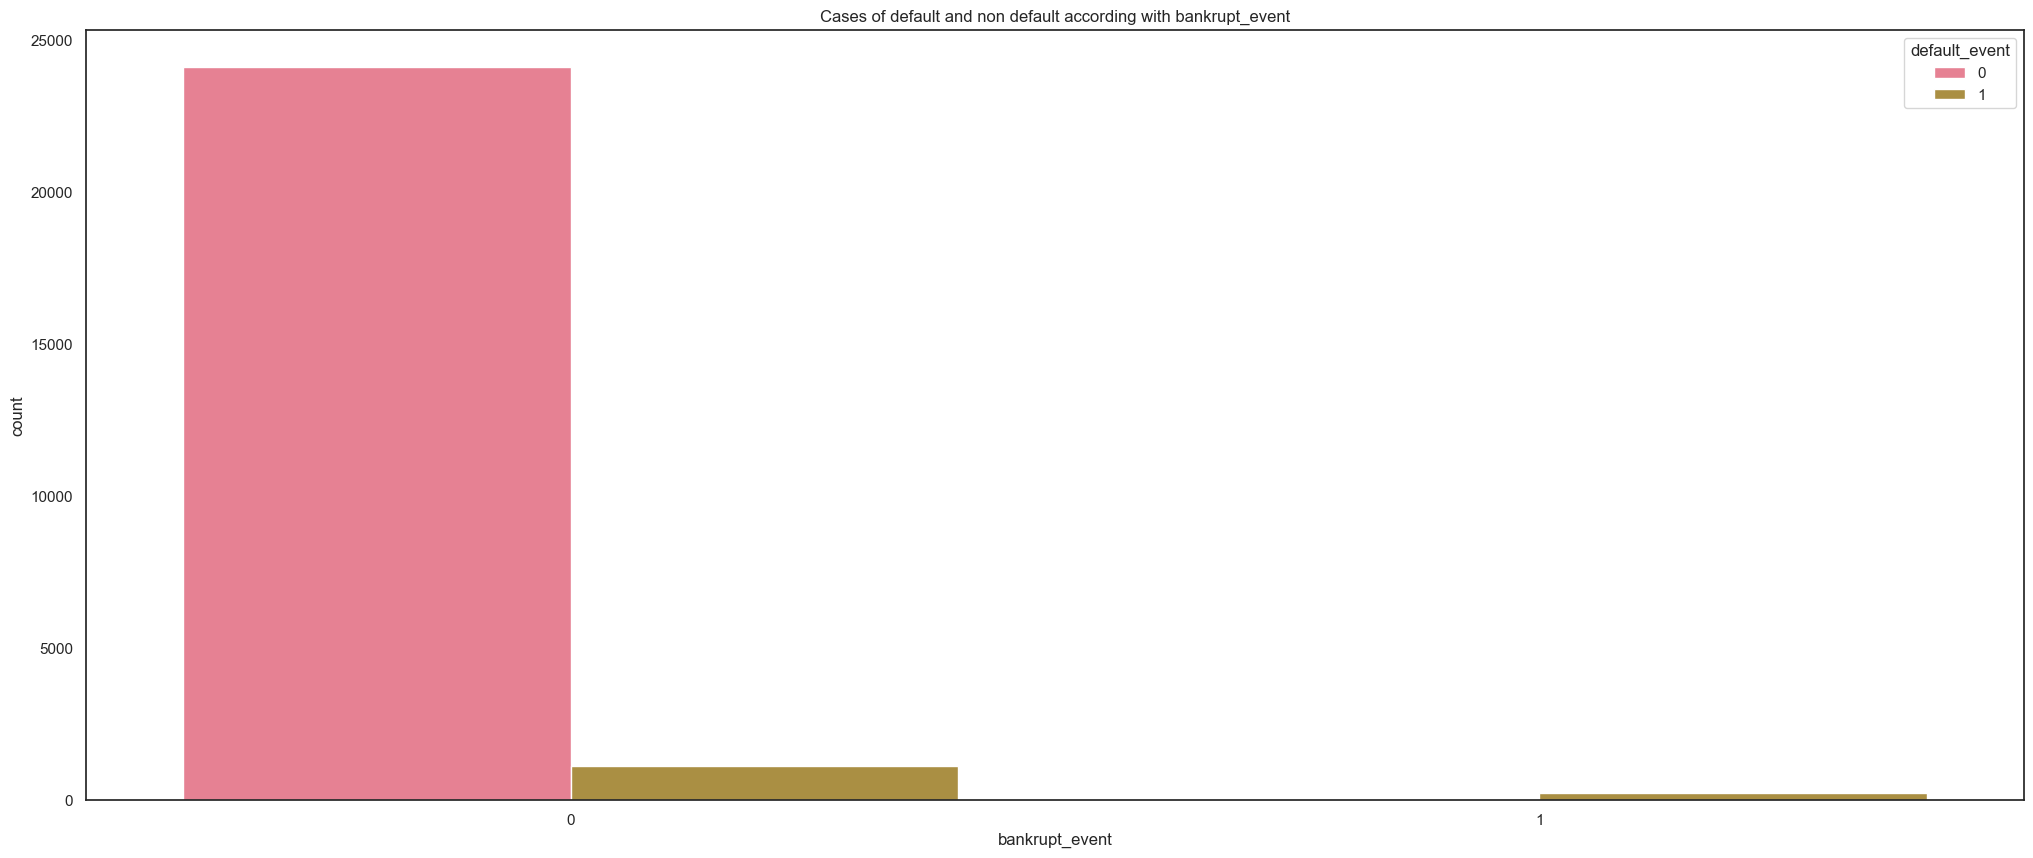

In [31]:
# Cases of default and non default , variable bankrupt_event
plt.figure(1,figsize = (25,10))
sns.countplot(hue = df2.default_event, x = df2.bankrupt_event)
plt.title('Cases of default and non default according with bankrupt_event')

## ok pl_flag, region, repayment_type

#'num_iva','pl_flag','region','repayment_type','arrears_status','arrears_segment',
#           'live_status','repaid_status','month','arrears_event','bankrupt_event','term_expiry_event','worst_arrears_status','avg_mia_6m',
#           'max_mia_6m','emp_length']

Text(0.5, 1.0, 'Cases of default and non default according with term_expiry_event')

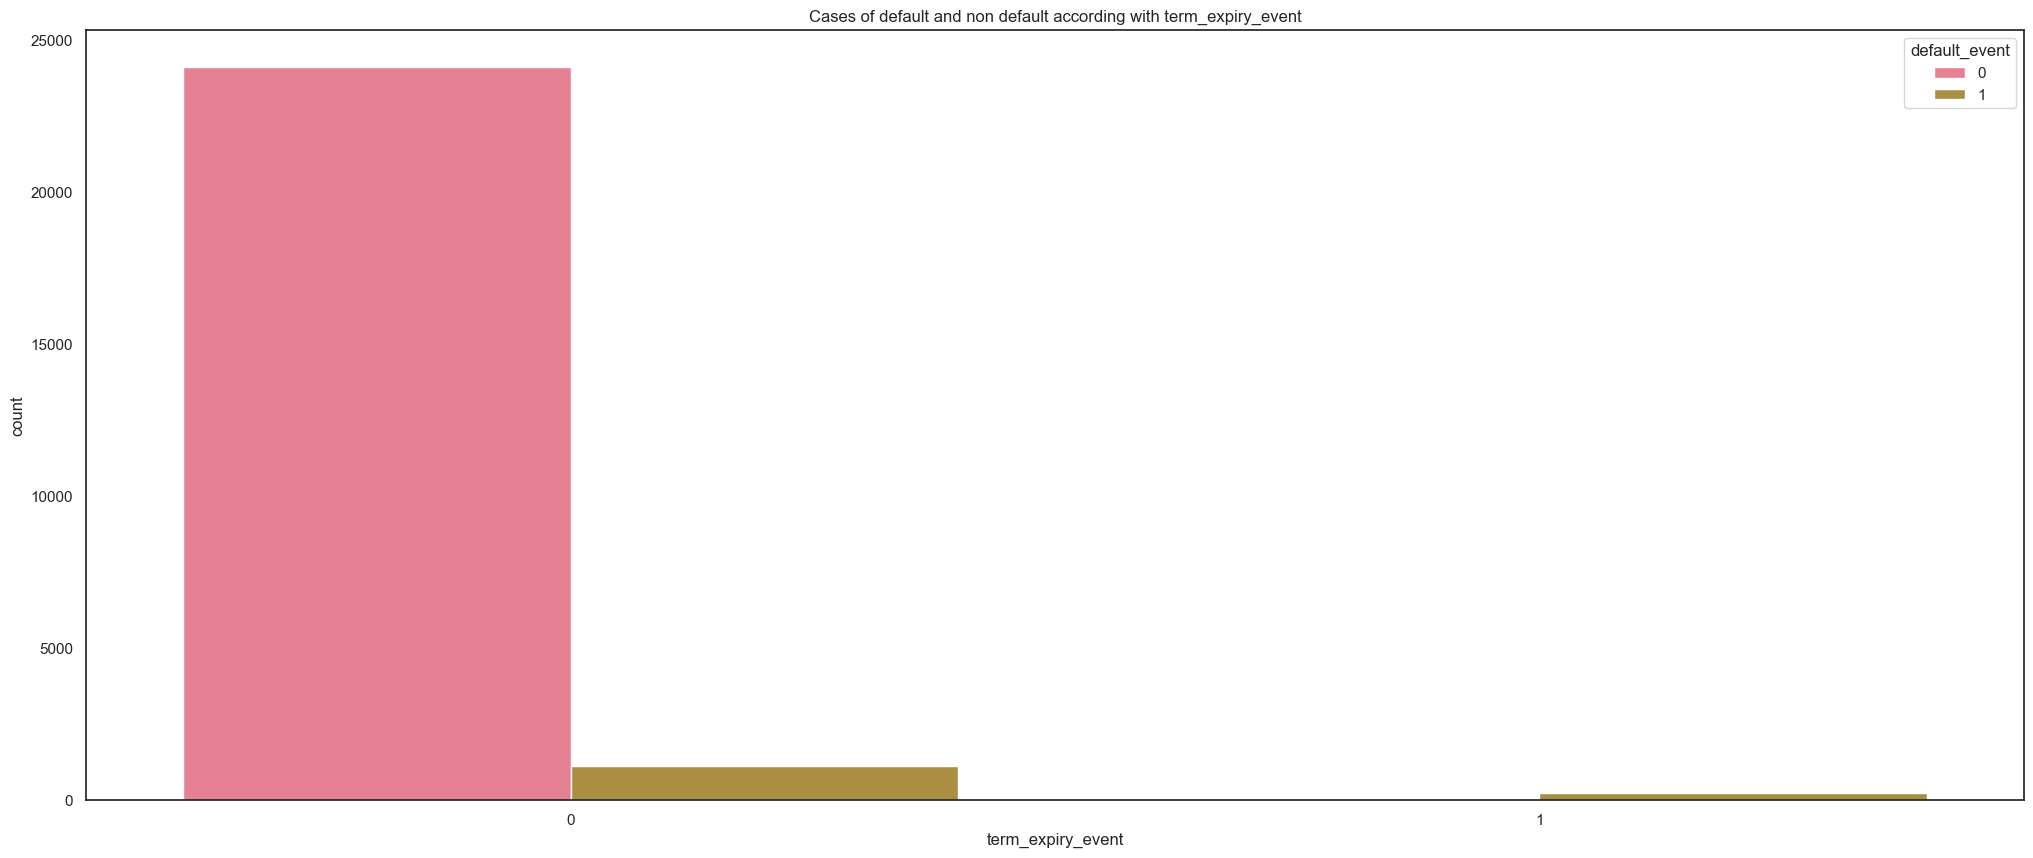

In [32]:
# Cases of default and non default , variable term_expiry_event
plt.figure(1,figsize = (25,10))
sns.countplot(hue = df2.default_event, x = df2.term_expiry_event)
plt.title('Cases of default and non default according with term_expiry_event')

## ok pl_flag, region, repayment_type

#'num_iva','pl_flag','region','repayment_type','arrears_status','arrears_segment',
#           'live_status','repaid_status','month','arrears_event','bankrupt_event','term_expiry_event','worst_arrears_status','avg_mia_6m',
#           'max_mia_6m','emp_length']

Text(0.5, 1.0, 'Cases of default and non default according with worst_arrears_status')

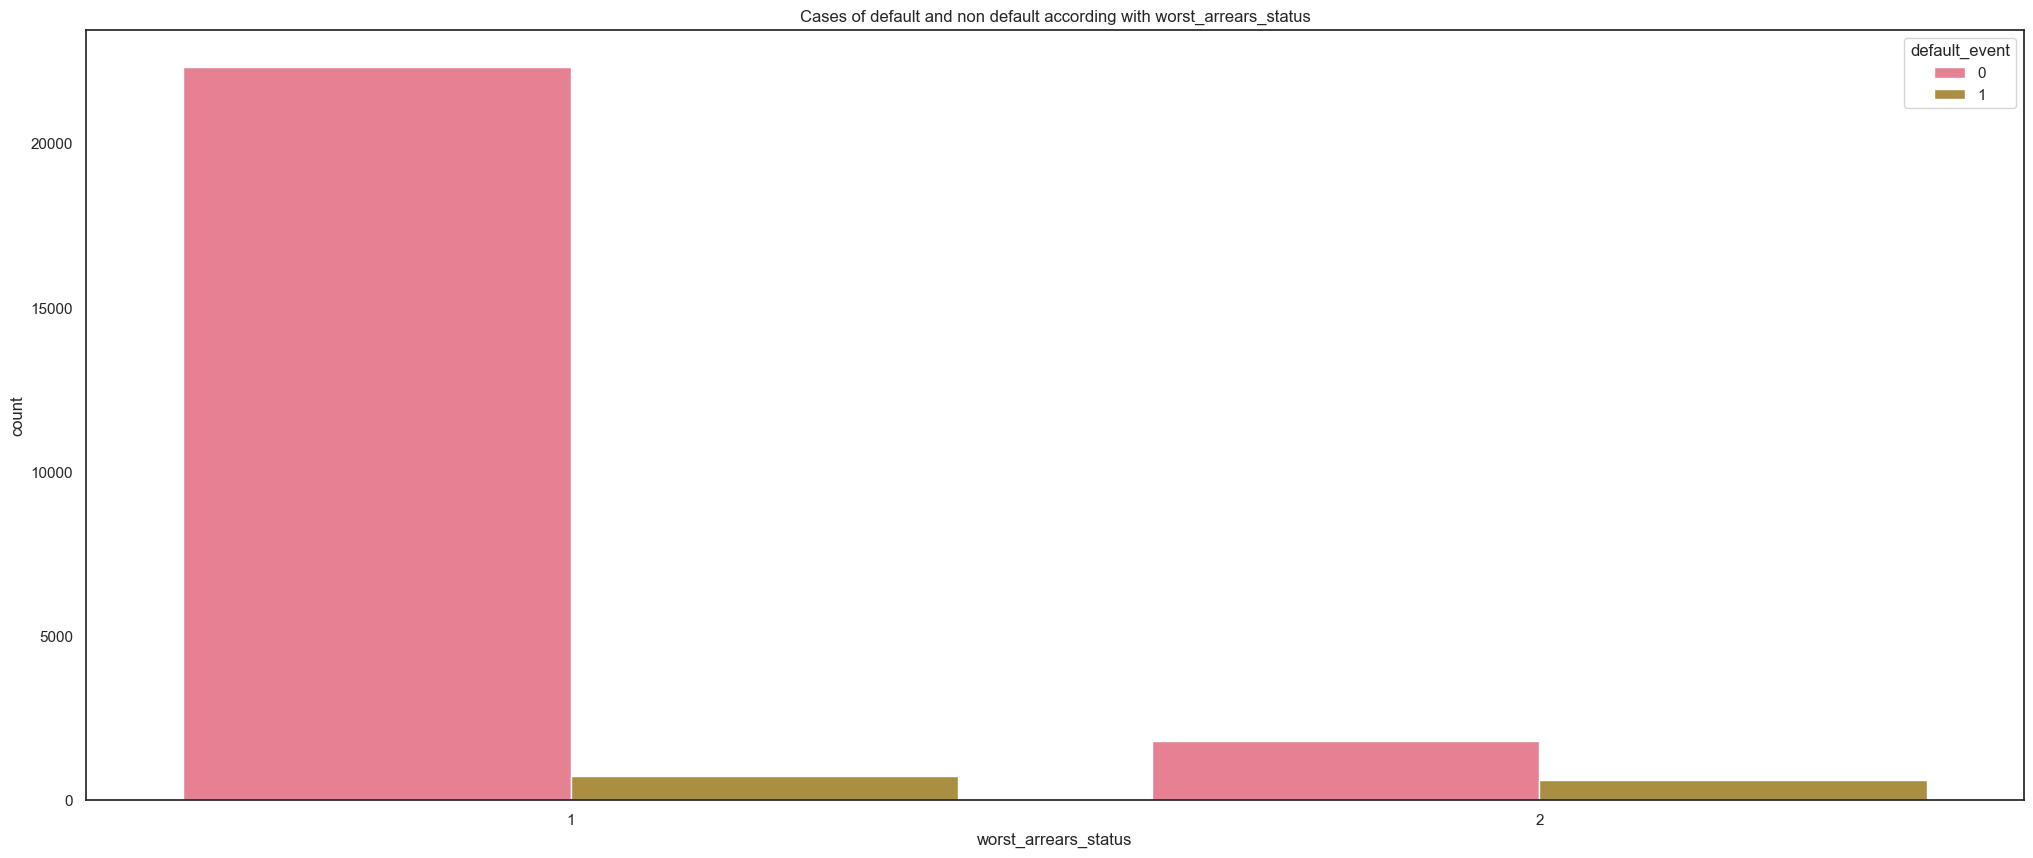

In [33]:
# Cases of default and non default , variable worst_arrears_status
plt.figure(1,figsize = (25,10))
sns.countplot(hue = df2.default_event, x = df2.worst_arrears_status)
plt.title('Cases of default and non default according with worst_arrears_status')

## ok pl_flag, region, repayment_type

#'num_iva','pl_flag','region','repayment_type','arrears_status','arrears_segment',
#           'live_status','repaid_status','month','arrears_event','bankrupt_event','term_expiry_event','worst_arrears_status','avg_mia_6m',
#           'max_mia_6m','emp_length']

Text(0.5, 1.0, 'Cases of default and non default according with avg_mia_6m')

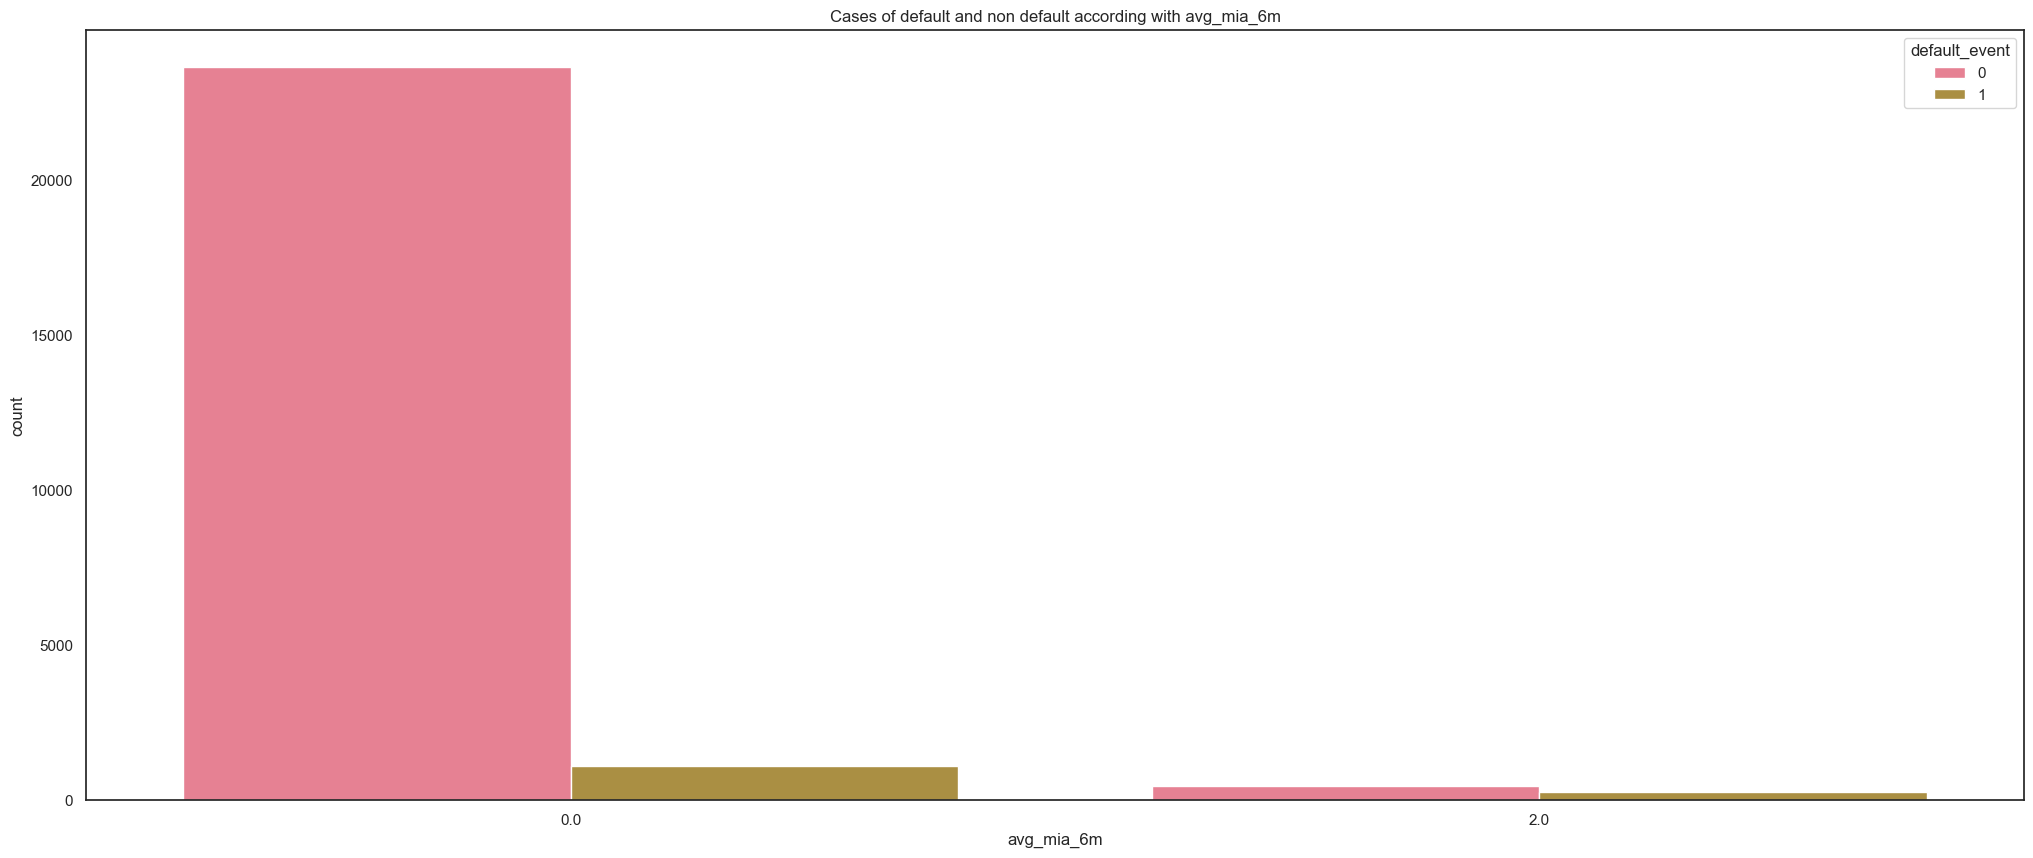

In [34]:
# Cases of default and non default , variable avg_mia_6m
plt.figure(1,figsize = (25,10))
sns.countplot(hue = df2.default_event, x = df2.avg_mia_6m)
plt.title('Cases of default and non default according with avg_mia_6m')

## ok pl_flag, region, repayment_type

#'num_iva','pl_flag','region','repayment_type','arrears_status','arrears_segment',
#           'live_status','repaid_status','month','arrears_event','bankrupt_event','term_expiry_event','worst_arrears_status','avg_mia_6m',
#           'max_mia_6m','emp_length']

Text(0.5, 1.0, 'Cases of default and non default according with max_mia_6m')

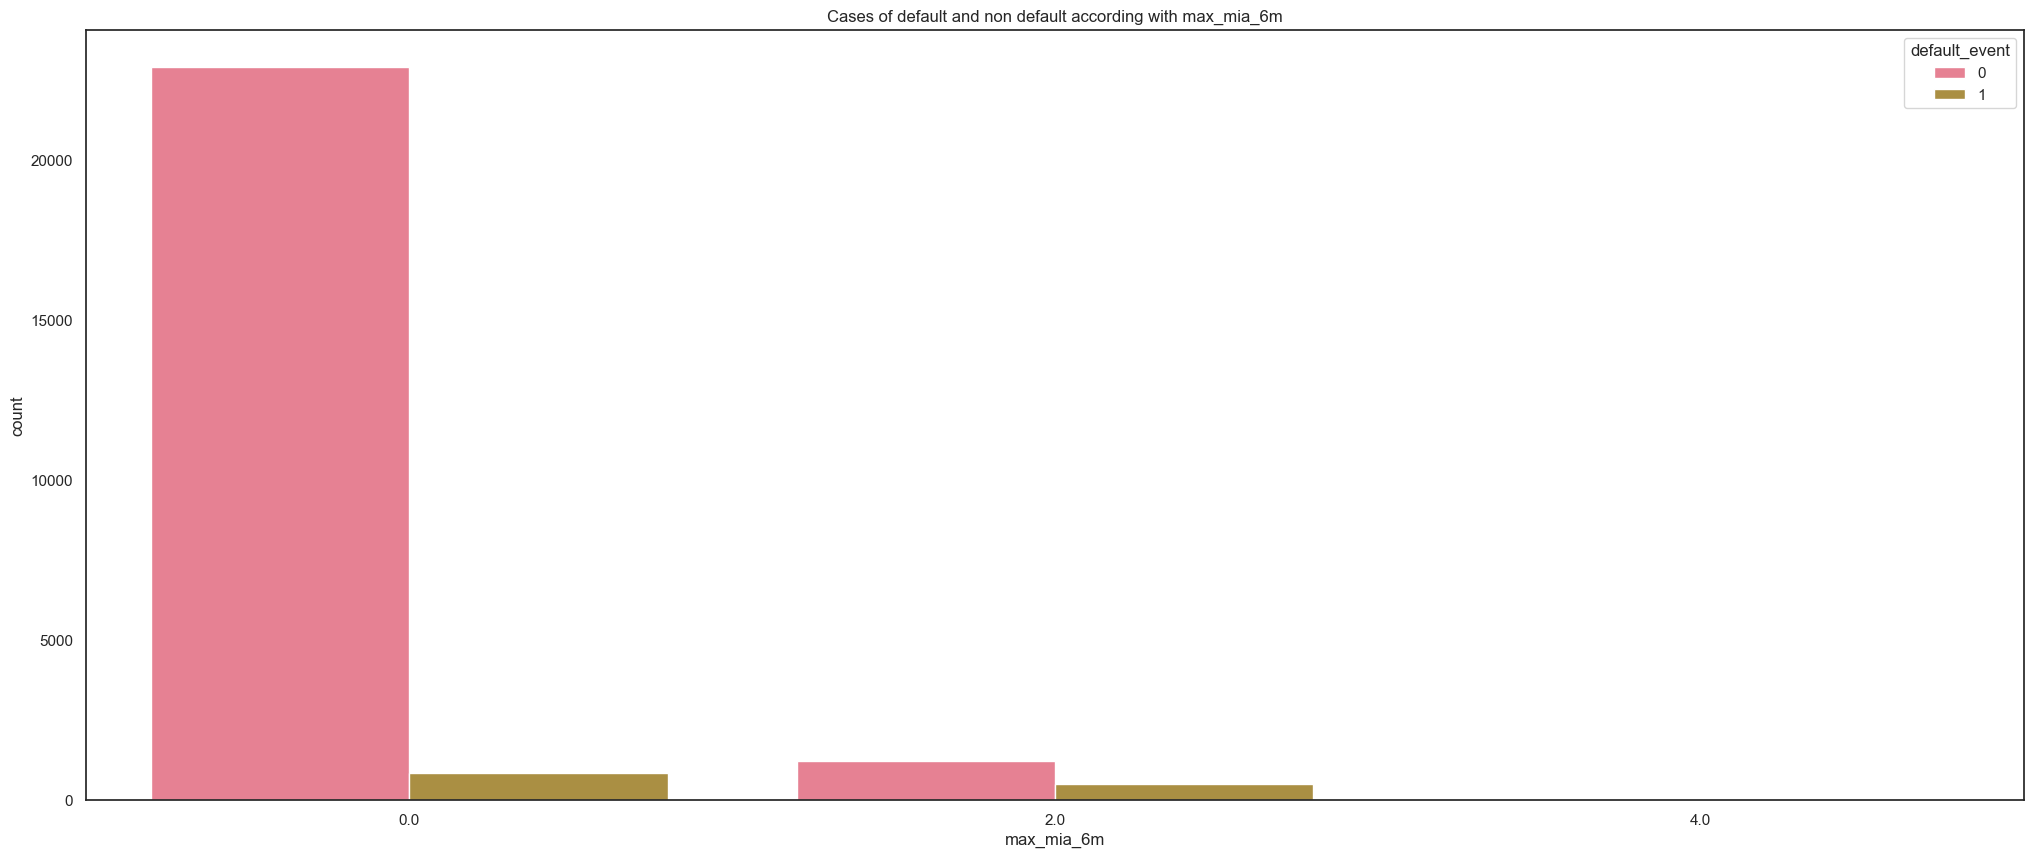

In [35]:
# Cases of default and non default , variable max_mia_6m
plt.figure(1,figsize = (25,10))
sns.countplot(hue = df2.default_event, x = df2.max_mia_6m)
plt.title('Cases of default and non default according with max_mia_6m')

## ok pl_flag, region, repayment_type

#'num_iva','pl_flag','region','repayment_type','arrears_status','arrears_segment',
#           'live_status','repaid_status','month','arrears_event','bankrupt_event','term_expiry_event','worst_arrears_status','avg_mia_6m',
#           'max_mia_6m','emp_length']

Text(0.5, 1.0, 'Cases of default and non default according with emp_length')

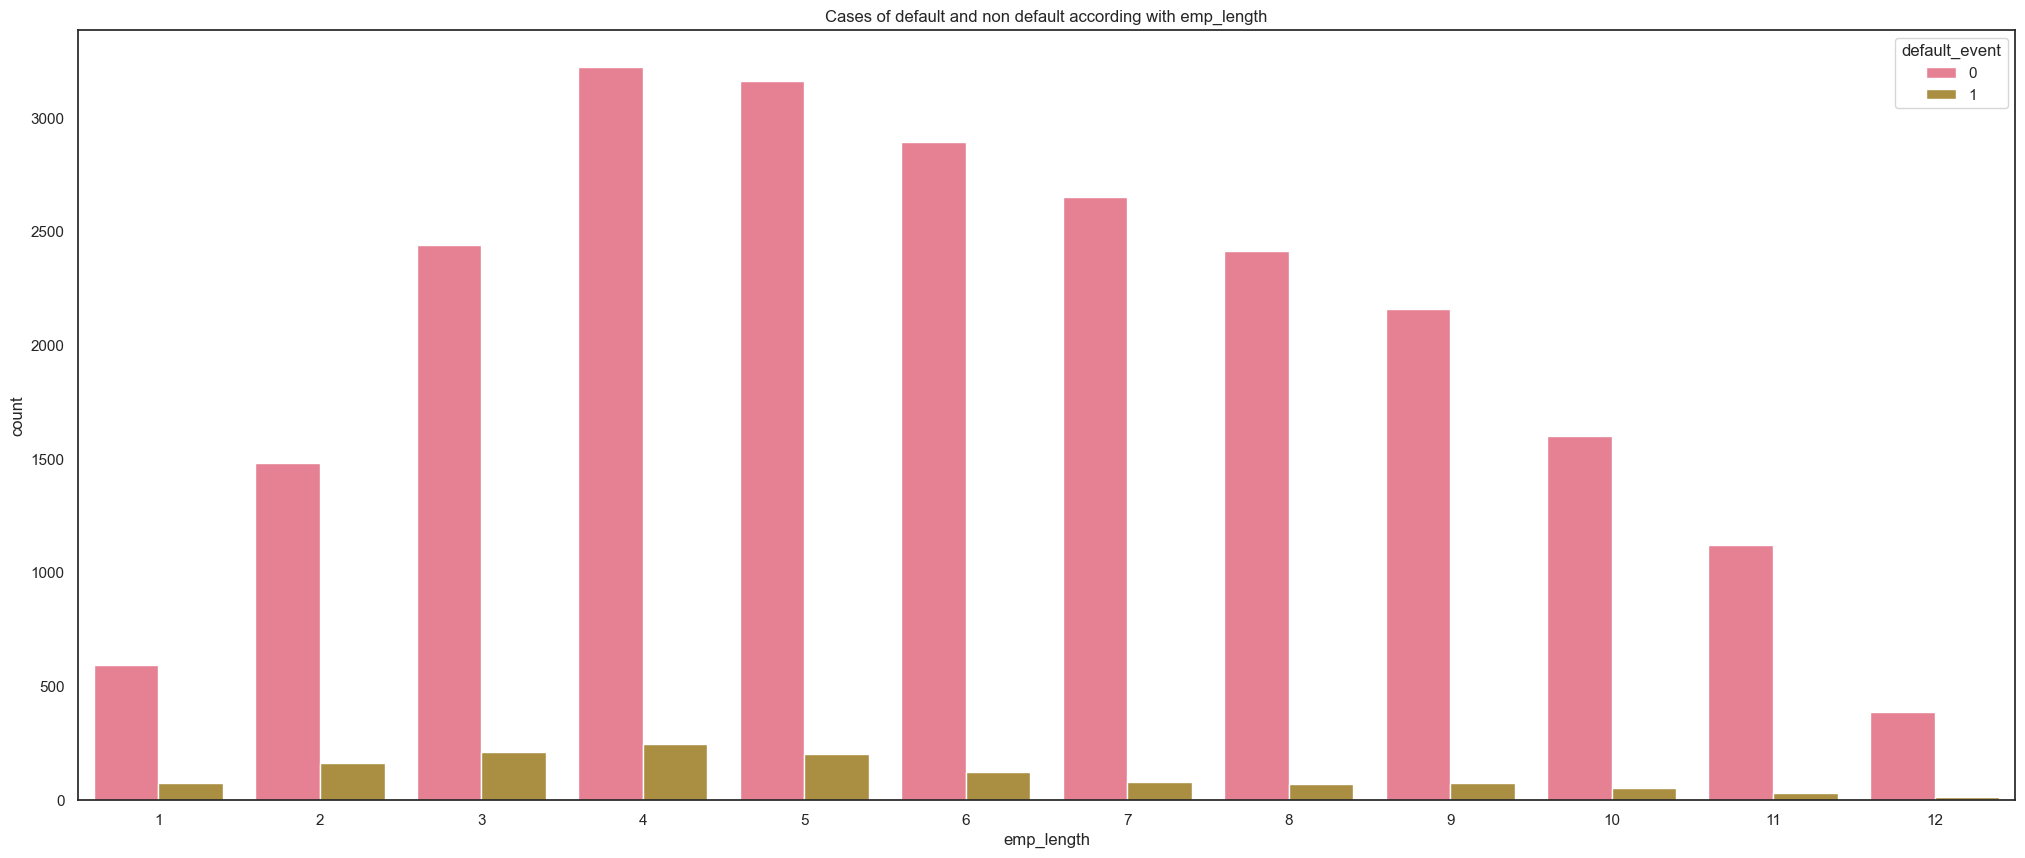

In [36]:
# Cases of default and non default , variable emp_length
plt.figure(1,figsize = (25,10))
sns.countplot(hue = df2.default_event, x = df2.emp_length)
plt.title('Cases of default and non default according with emp_length')

## ok pl_flag, region, repayment_type, emp_length

#'num_iva','pl_flag','region','repayment_type','arrears_status','arrears_segment',
#           'live_status','repaid_status','month','arrears_event','bankrupt_event','term_expiry_event','worst_arrears_status','avg_mia_6m',
#           'max_mia_6m','emp_length']

In [37]:
df2[var_con].describe(percentiles = [0.01,.45,.55,0.99]).T

,count,mean,std,min,1%,45%,50%,55%,99%,max
monthly_installment,25465.0,557.798681,310.878336,0.0100,15.3304,476.9080,502.8000,530.8640,1636.412400,5.181400e+03
loan_balance,25465.0,98969.540408,67201.739437,0.2000,816.8904,79957.0840,85446.0800,91747.8040,345982.436800,9.838437e+05
bureau_score,25465.0,391.537679,110.119465,-125.0000,135.0000,386.0000,404.0000,421.0000,584.360000,7.020000e+02
time_since_bankrupt,25465.0,2.350756,11.329791,0.0000,0.0000,0.0000,0.0000,0.0000,66.000000,1.200000e+02
time_since_ccj,25465.0,4.040958,13.952894,0.0000,0.0000,0.0000,0.0000,0.0000,68.000000,1.200000e+02
ccj_amount,25465.0,638.874573,15777.212719,0.0000,0.0000,0.0000,0.0000,0.0000,14977.880000,2.449929e+06
min_months_since_bankrupt,25465.0,0.327194,4.232650,0.0000,0.0000,0.0000,0.0000,0.0000,0.000000,7.200000e+01
ltv,25465.0,0.579653,0.246780,0.0001,0.0077,0.5915,0.6284,0.6598,1.025000,1.459500e+00
arrears_months,25465.0,0.078958,0.335876,0.0000,0.0000,0.0000,0.0000,0.0000,1.969248,3.000000e+00
mob,25465.0,117.128451,15.204258,4.0000,100.0000,112.0000,113.0000,115.0000,160.000000,1.650000e+02


##### Visualmente podemos considerar pl_flag, region, repayment_type, emp_length como las variables categoricas para entrar dentro del análisis

array([[<Axes: title={'center': 'monthly_installment'}>,
        <Axes: title={'center': 'loan_balance'}>,
        <Axes: title={'center': 'bureau_score'}>,
        <Axes: title={'center': 'time_since_bankrupt'}>],
       [<Axes: title={'center': 'time_since_ccj'}>,
        <Axes: title={'center': 'ccj_amount'}>,
        <Axes: title={'center': 'min_months_since_bankrupt'}>,
        <Axes: title={'center': 'ltv'}>],
       [<Axes: title={'center': 'arrears_months'}>,
        <Axes: title={'center': 'mob'}>,
        <Axes: title={'center': 'remaining_mat'}>,
        <Axes: title={'center': 'loan_term'}>],
       [<Axes: title={'center': 'max_arrears_12m'}>,
        <Axes: title={'center': 'max_arrears_bal_6m'}>,
        <Axes: title={'center': 'avg_bal_6m'}>,
        <Axes: title={'center': 'avg_bureau_score_6m'}>],
       [<Axes: title={'center': 'cc_util'}>,
        <Axes: title={'center': 'annual_income'}>,
        <Axes: title={'center': 'months_since_recent_cc_delinq'}>,
        <A

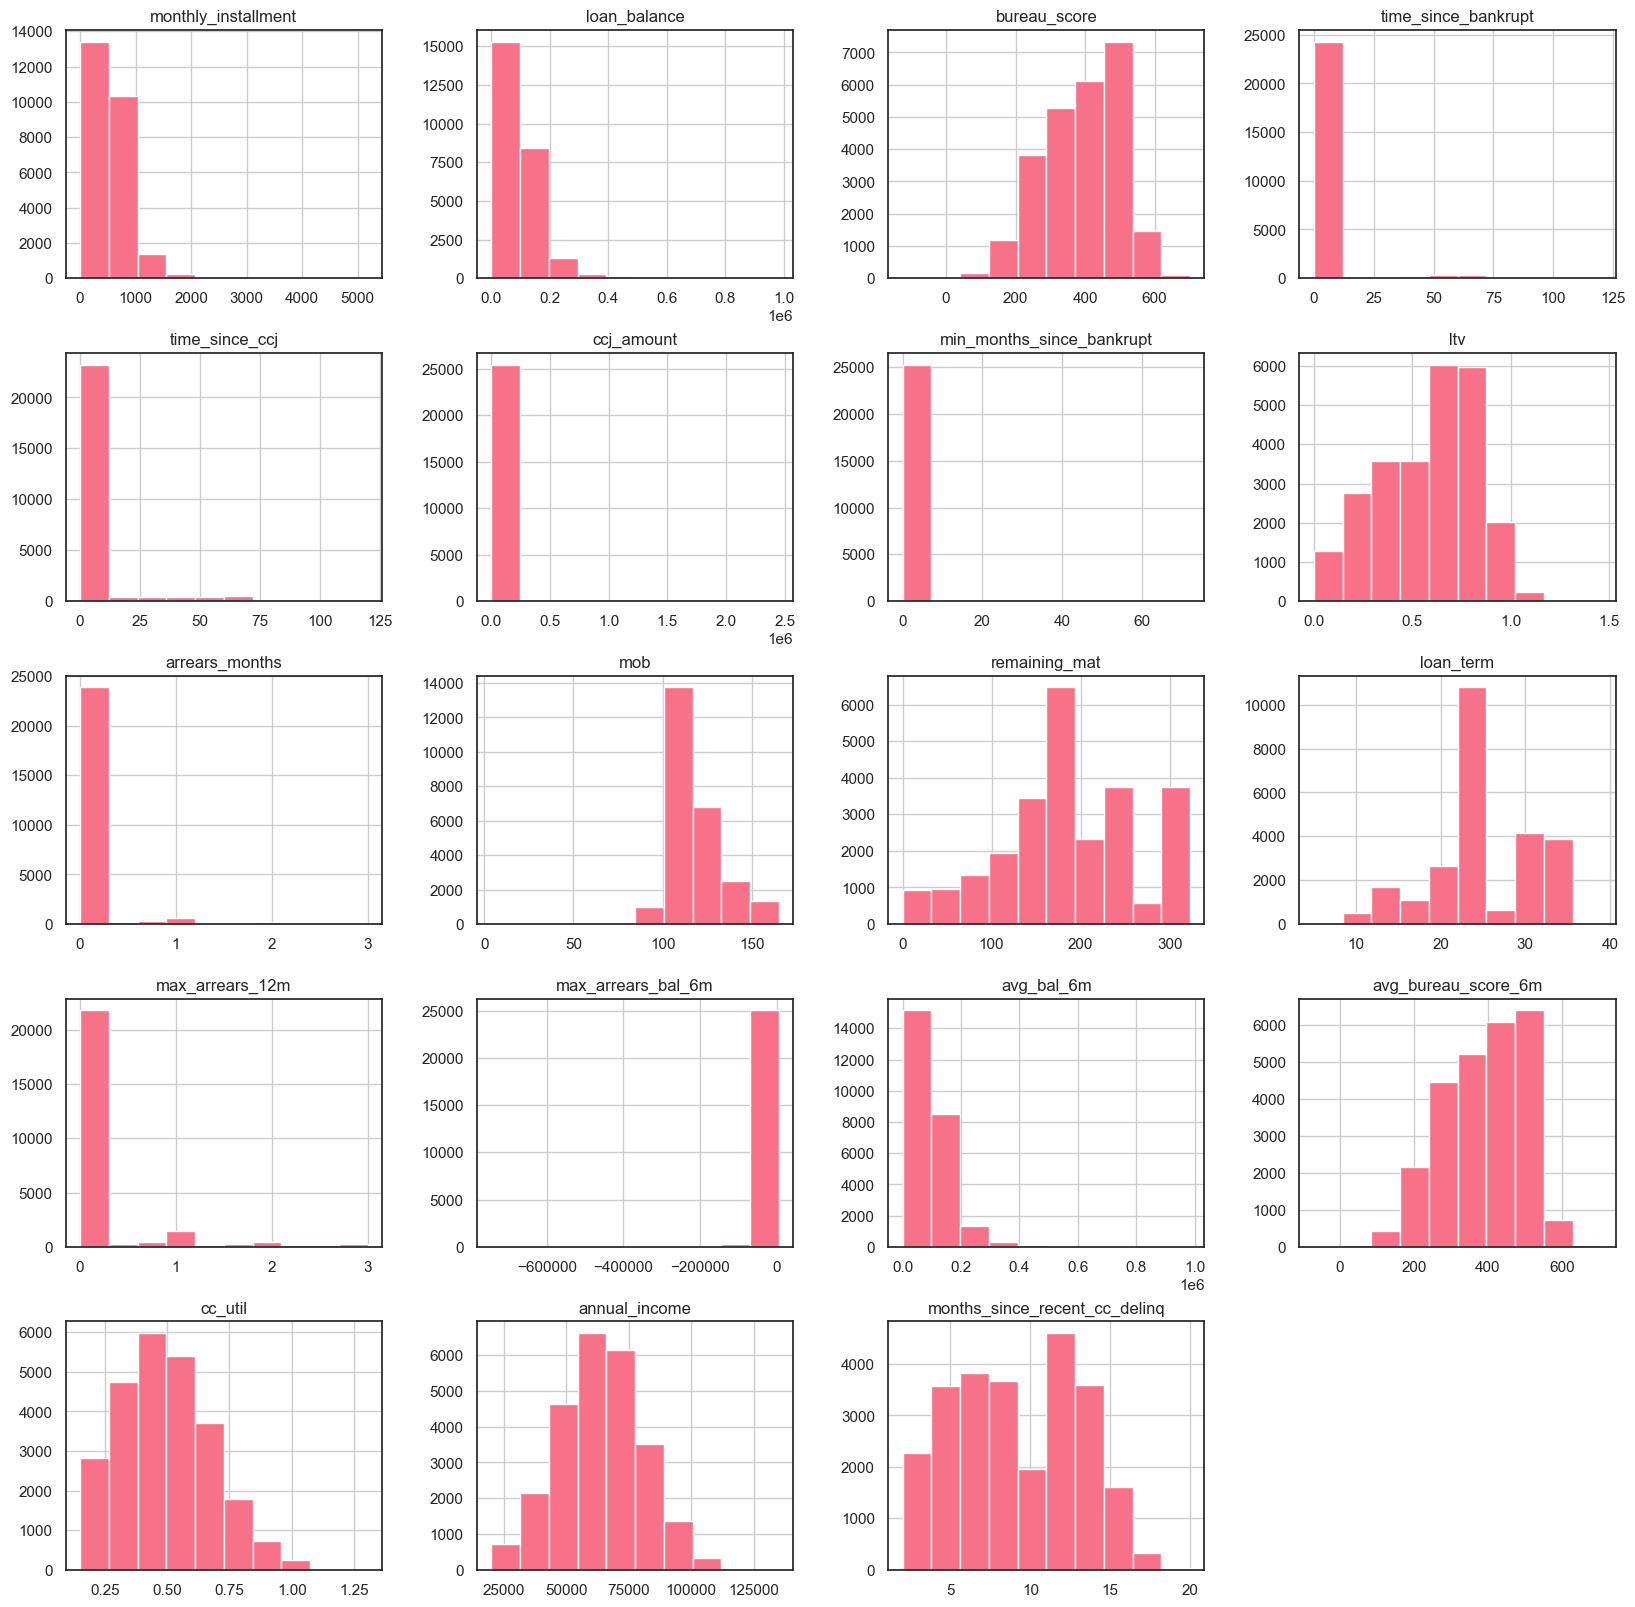

In [38]:
df2[var_con].hist(figsize = (20,20))

#### Eliminación de valores extremos (outliers)

In [39]:
ext = df2[var_con].describe(percentiles=[.001,.999] ).T[['0.1%','99.9%']].reset_index()

In [40]:
ext

,index,0.1%,99.9%
0,monthly_installment,0.030000,2585.010080
1,loan_balance,1.000000,561102.210240
2,bureau_score,44.464000,661.000000
3,time_since_bankrupt,0.000000,78.000000
4,time_since_ccj,0.000000,78.000000
5,ccj_amount,0.000000,45049.888000
6,min_months_since_bankrupt,0.000000,66.000000
7,ltv,0.000200,1.161845
8,arrears_months,0.000000,2.887838
9,mob,28.000000,164.000000


#### Process

In [41]:
for v, li, ls in ext.values:
    df2[f'ol_{v}'] = (( df2[v] < li ) | ( df2[v] > ls )).astype(int)
    

In [42]:
df2['ext'] = df2.filter(like='ol_').max(axis = 1)

In [43]:
df2['ext'].value_counts(True)*100

ext
0    97.950128
1     2.049872
Name: proportion, dtype: float64

In [44]:
df3 = df2.loc[df2['ext'] == 0].reset_index(drop = True).drop(['ext'],axis= 1)

In [45]:
df3.default_event.value_counts(normalize = True)*100


default_event
0    95.068757
1     4.931243
Name: proportion, dtype: float64

In [46]:
df2.default_event.value_counts(normalize = True)*100


default_event
0    94.753583
1     5.246417
Name: proportion, dtype: float64

#### Validación de Distribución Alterada
#### Validación con p-value

In [47]:

from scipy.stats import ks_2samp


In [48]:
# Validación de Distribución Alterada
# Si el valor KS > .1 se elimina la variable, porque se alteró 
pd.DataFrame( map( lambda v: (v , ks_2samp(df2[v] , df3[v] ).statistic ) , var_con  ), columns=['var','ks']  )

,var,ks
0,monthly_installment,0.002810
1,loan_balance,0.002702
2,bureau_score,0.002208
3,time_since_bankrupt,0.001741
4,time_since_ccj,0.001625
5,ccj_amount,0.001338
6,min_months_since_bankrupt,0.001150
7,ltv,0.001804
8,arrears_months,0.002971
9,mob,0.001146


In [49]:
# Validación de Distribución Alterada
# Si el valor KS > .1 se elimina la variable, porque se alteró 
# es mejor el criterio de P-value
pd.DataFrame( map( lambda v: (v , ks_2samp(df2[v] , df3[v] ).pvalue ) , var_con  ), columns=['var','p-value']  )

,var,p-value
0,monthly_installment,0.999963
1,loan_balance,0.999986
2,bureau_score,1.000000
3,time_since_bankrupt,1.000000
4,time_since_ccj,1.000000
5,ccj_amount,1.000000
6,min_months_since_bankrupt,1.000000
7,ltv,1.000000
8,arrears_months,0.999874
9,mob,1.000000


#### ¿Cómo se interpreta el valor p en la prueba de Kolmogorov-Smirnov?
#### Un valor p pequeño indica que hay evidencia significativa para rechazar la hipótesis nula de que las distribuciones son iguales.
#### El test estadístico de Kolmogorov–Smirnov para dos muestras está disponible en la función ks_2samp() de la librería scipy.stats. La hipótesis nula de este test considera que ambas muestras proceden de la misma distribución, por lo tanto, solo cuando el p-value estimado es muy pequeño (significativo), se puede considerar que hay evidencias en contra de que la distribución de ambas muestras es la misma.

#### https://cienciadedatos.net/documentos/pystats08-comparacion-distribuciones-test-kolmogorov-smirnov-python

array([[<Axes: title={'center': 'monthly_installment'}>,
        <Axes: title={'center': 'loan_balance'}>,
        <Axes: title={'center': 'bureau_score'}>,
        <Axes: title={'center': 'time_since_bankrupt'}>],
       [<Axes: title={'center': 'time_since_ccj'}>,
        <Axes: title={'center': 'ccj_amount'}>,
        <Axes: title={'center': 'min_months_since_bankrupt'}>,
        <Axes: title={'center': 'ltv'}>],
       [<Axes: title={'center': 'arrears_months'}>,
        <Axes: title={'center': 'mob'}>,
        <Axes: title={'center': 'remaining_mat'}>,
        <Axes: title={'center': 'loan_term'}>],
       [<Axes: title={'center': 'max_arrears_12m'}>,
        <Axes: title={'center': 'max_arrears_bal_6m'}>,
        <Axes: title={'center': 'avg_bal_6m'}>,
        <Axes: title={'center': 'avg_bureau_score_6m'}>],
       [<Axes: title={'center': 'cc_util'}>,
        <Axes: title={'center': 'annual_income'}>,
        <Axes: title={'center': 'months_since_recent_cc_delinq'}>,
        <A

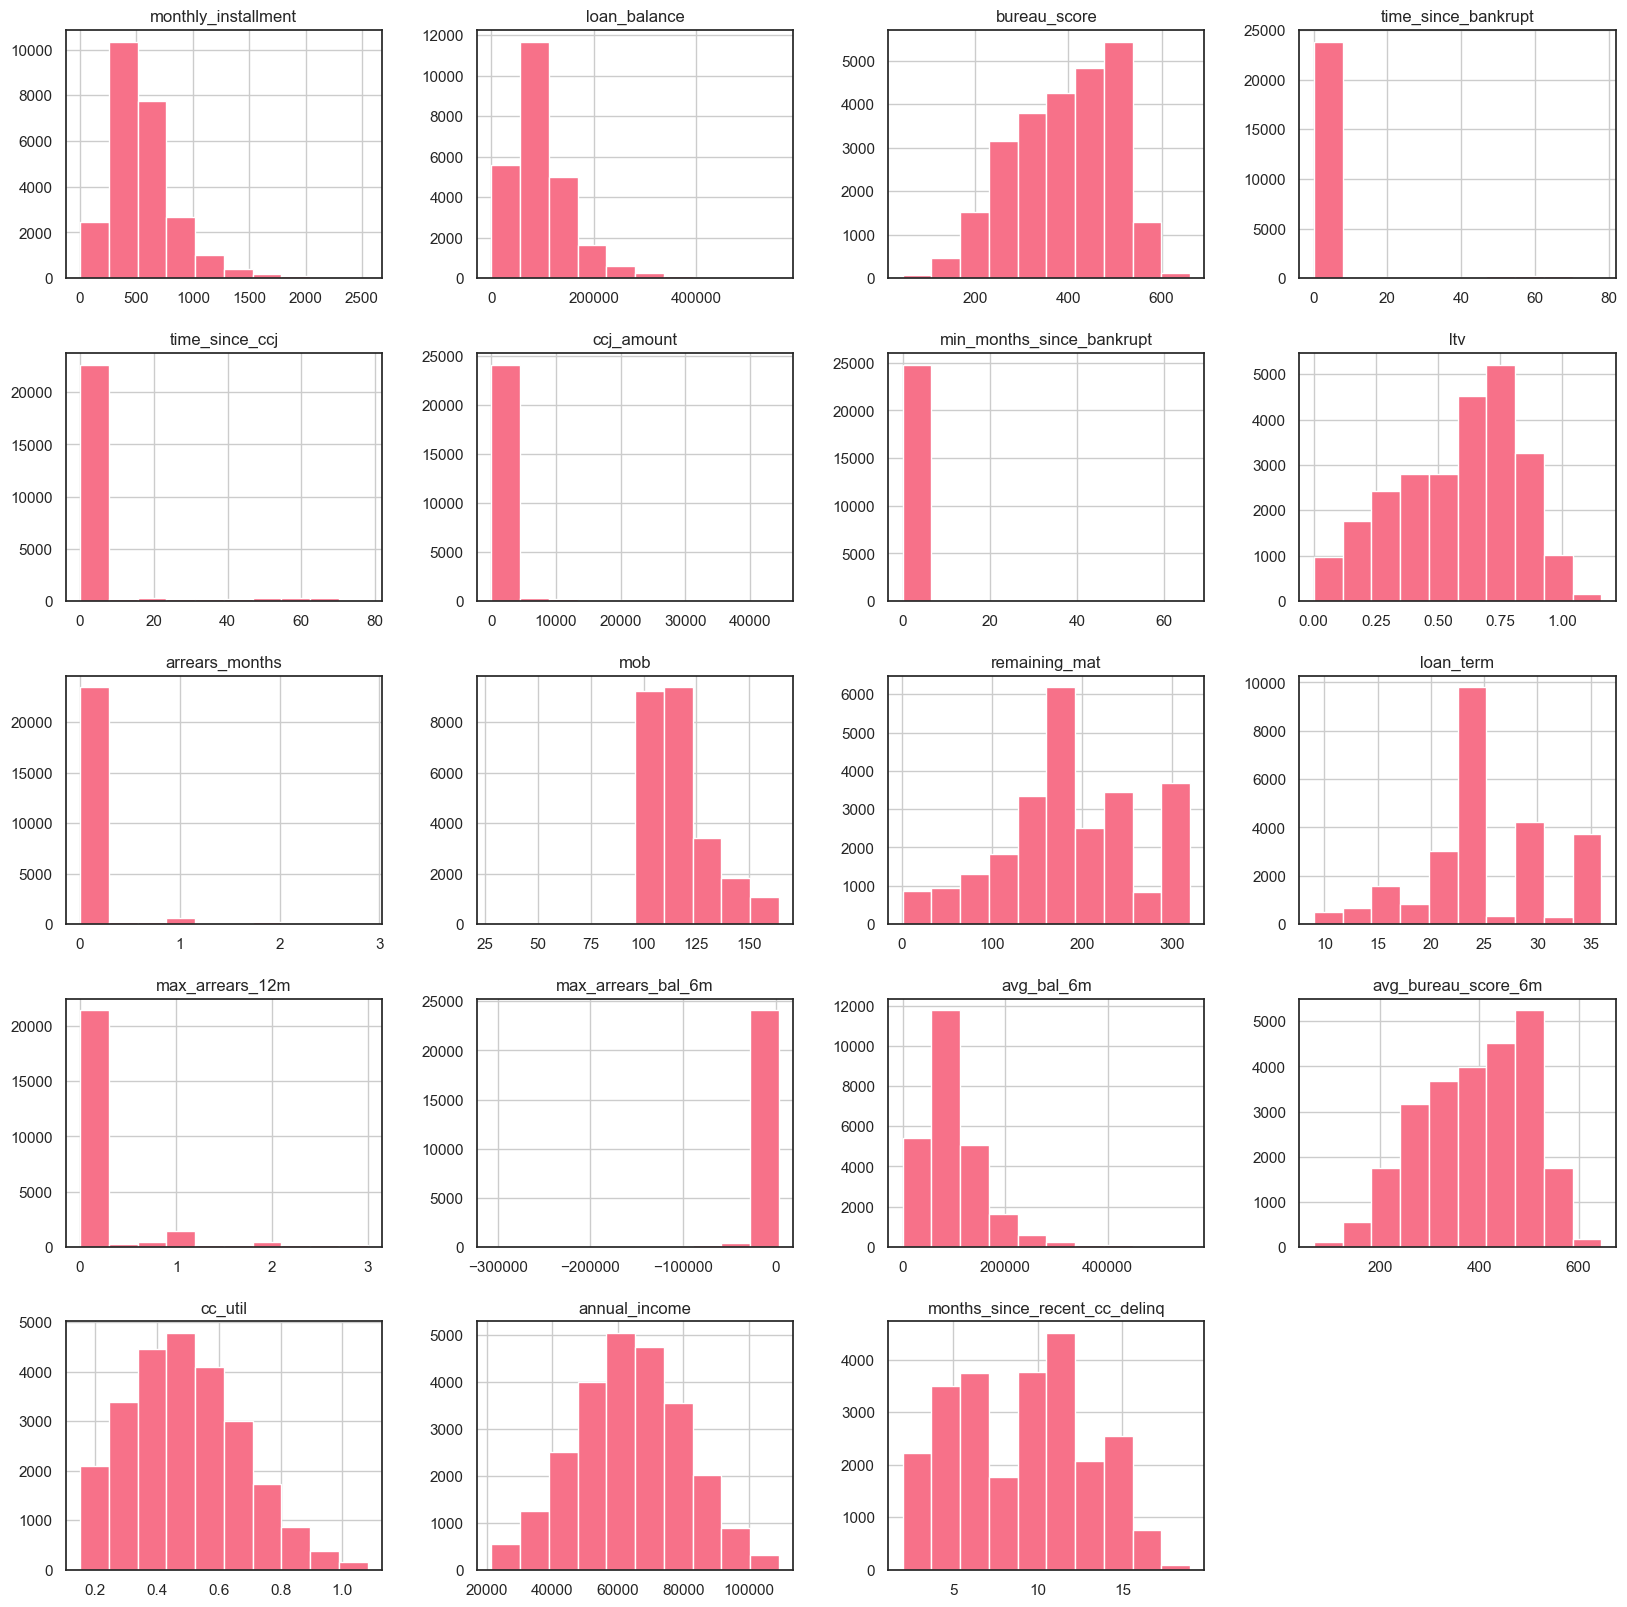

In [50]:
df3[var_con].hist(figsize = (20,20))

In [51]:
# Visualmente podemos considerar 
# 'monthly_installment','loan_balance','bureau_score',
# 'ltv','mob','remaining_mat','loan_term','avg_bal_6m','avg_bureau_score_6m',
# 'cc_util','annual_income','months_since_recent_cc_delinq'
# para entrar dentro del análisis

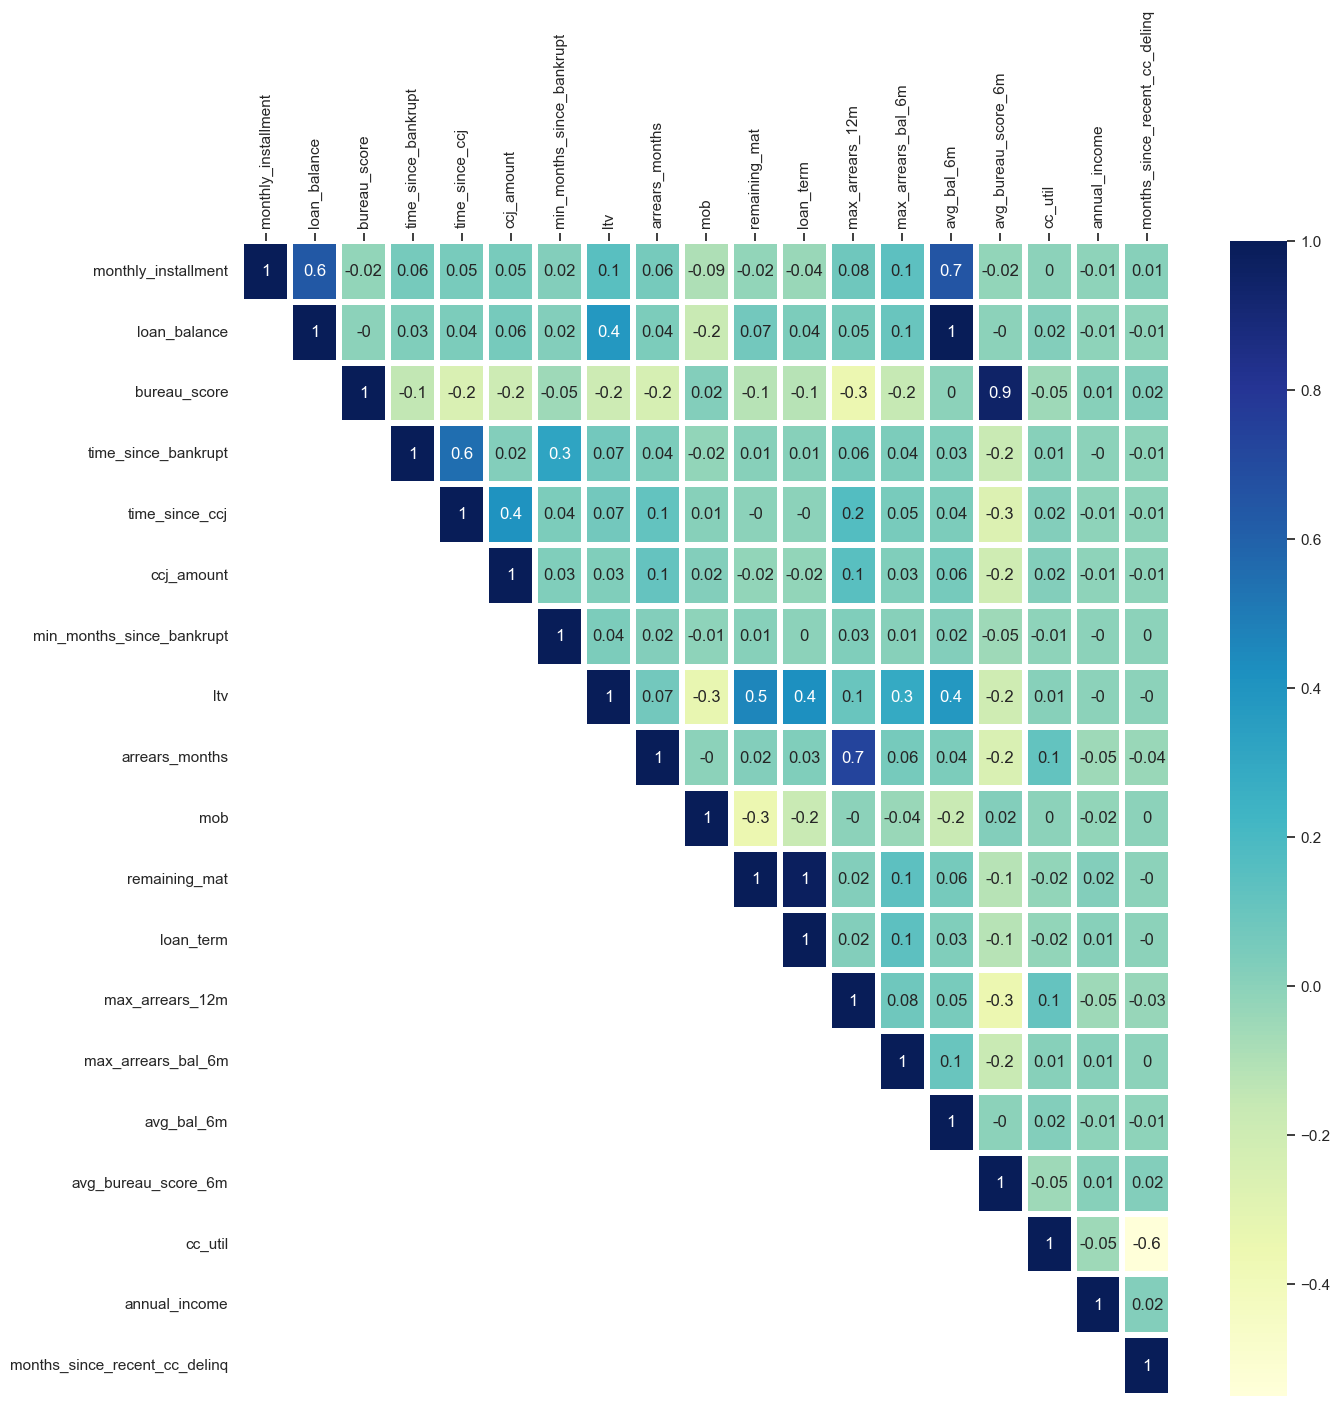

In [52]:
corr_df3_var_con = df3[var_con].corr()
mask = np.tri(corr_df3_var_con.shape[0],corr_df3_var_con.shape[1], k = -1)
plot_corr_up = plt.subplots(figsize = (15, 15))
plot_corr_up = sns.heatmap(round(corr_df3_var_con,2),mask = mask ,annot = True, cmap = 'YlGnBu', linewidths = 3, fmt = '.1g')
plot_corr_up.set(xlabel = "", ylabel = "")
plot_corr_up.xaxis.tick_top()
plot_corr_up.tick_params(axis = 'x', rotation = 90)

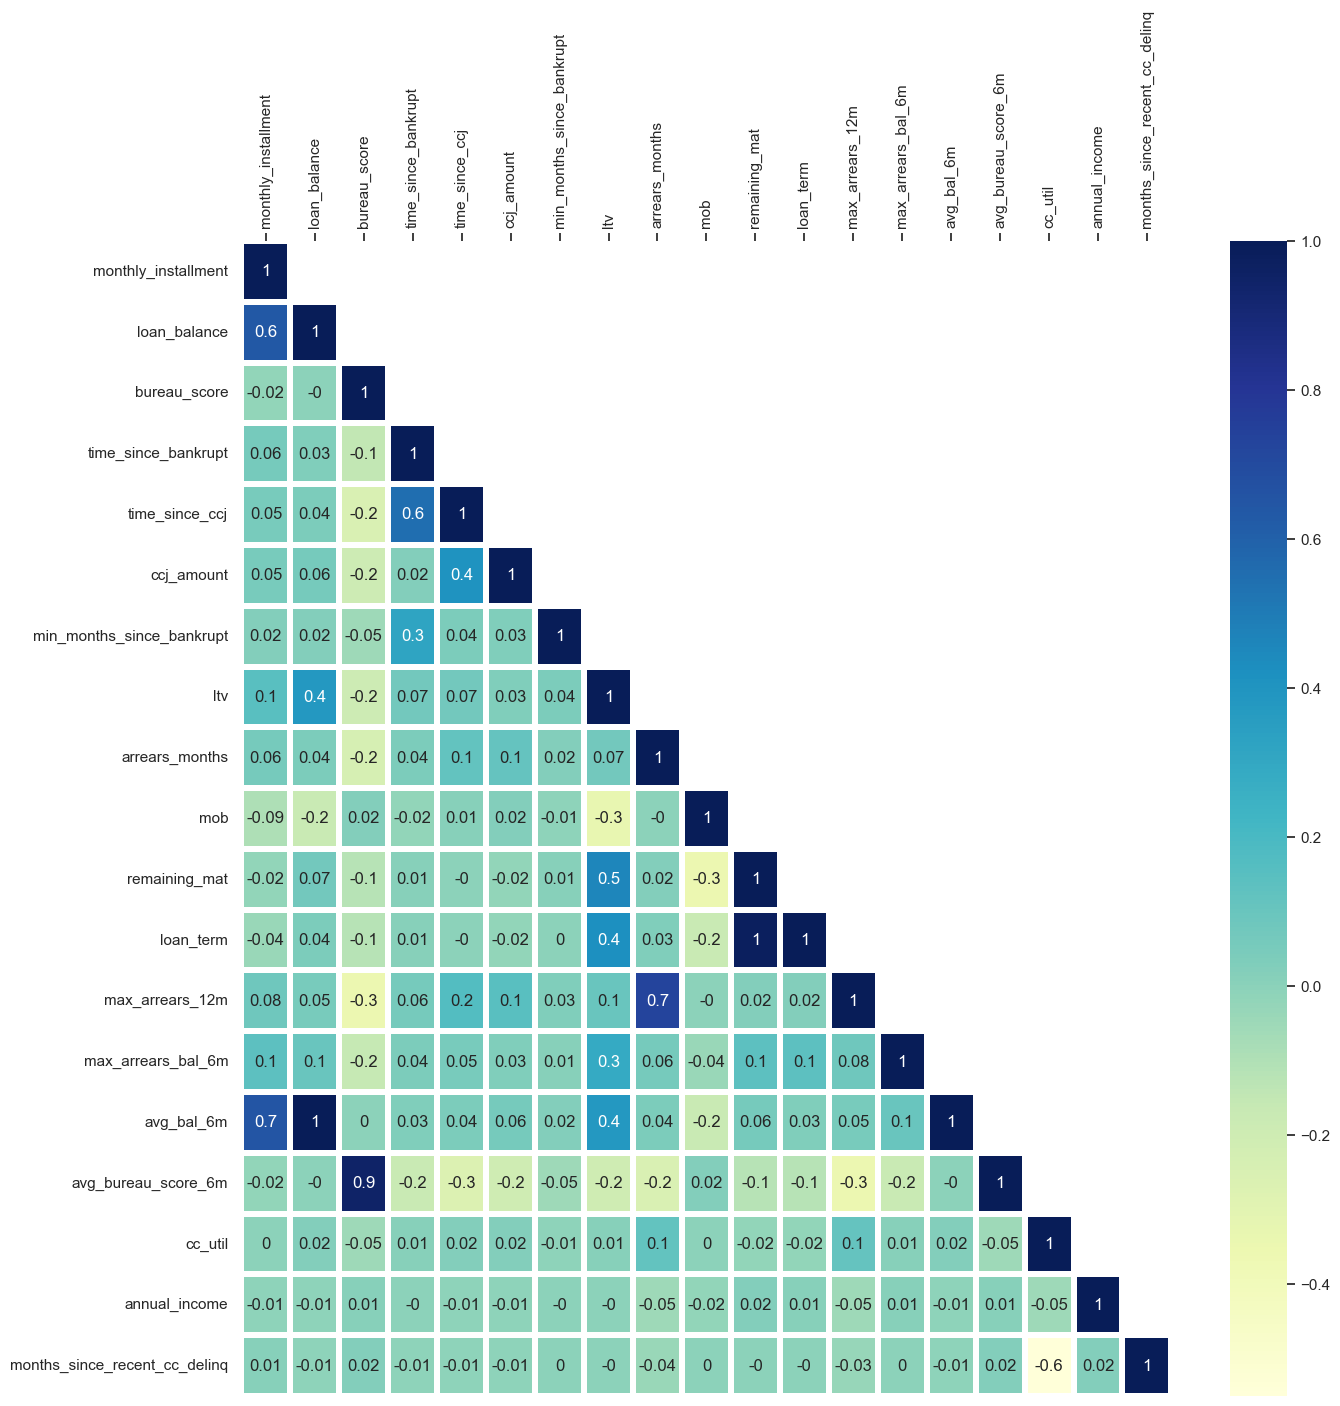

In [53]:
mask_lw = mask.T
plot_corr_lw = plt.subplots(figsize = (15, 15))
plot_corr_lw = sns.heatmap(round(corr_df3_var_con,2),mask = mask_lw ,annot = True, cmap = 'YlGnBu', linewidths = 3, fmt = '.1g')
plot_corr_lw.set(xlabel = "", ylabel = "")
plot_corr_lw.xaxis.tick_top()
plot_corr_lw.tick_params(axis = 'x', rotation = 90)

In [54]:
# Revisando la correlación, estás serían las posibles varieables a descartar
# annual income
# cc_util
# avg_bal_6m, está altamente correlacionada con monthly_atatement y loan _balance. Se elige loan_balance
# max_arrears_bal_6m
# loan_term
# remaining_mat
# min_months_since_bankrupt
# ccj_amount
# time_since_ccj

# En conclusion con la correlación y los histogramas podemos considerar 
# las siguientes variables para entrar dentro del análisis
# 'monthly_installment','loan_balance','bureau_score',
# 'ltv','mob','','','','avg_bureau_score_6m',
# '','annual_income','months_since_recent_cc_delinq'

#var_con2 = ['monthly_installment','loan_balance','bureau_score','ltv','mob', 
#            'avg_bureau_score_6m', 'annual_income', 'months_since_recent_cc_delinq']

#### 3.2 Identificación de variables unarias

In [55]:
# se sacan las variables : 
# var_cat no aplicables
# num_bankrupt
# num_bankrupt_iva
# num_iva
# arrears_status
# arrears_segment
# live_status
# repaid_status
# month
# arrears_event
# bannkrupt_event
# term_expiry_event
# avg_mia_6m
# max_mia_6m
# dentro de la lista de var_cat debido a que se consideran como variables unarias
# es decir; que la mayor parte de la información se concentra en 
# una categoría en particular

# las nuevas variables categoricas
var_cat = ['num_ccj','pl_flag','region','repayment_type','worst_arrears_status','emp_length']
 
# estás las acabo de mater pl_flag, region, repayment_type, emp_length

##### Discretización de variables, Optimal Binnig

In [56]:
from optbinning import BinningProcess, OptimalBinning

(CVXPY) Jan 30 09:08:30 PM: Encountered unexpected exception importing solver GLOP:
RuntimeError('Unrecognized new version of ortools (9.8.3296). Expected < 9.8.0. Please open a feature request on cvxpy to enable support for this version.')
(CVXPY) Jan 30 09:08:30 PM: Encountered unexpected exception importing solver PDLP:
RuntimeError('Unrecognized new version of ortools (9.8.3296). Expected < 9.8.0. Please open a feature request on cvxpy to enable support for this version.')


In [57]:
#from sklearn.preprocessing import KBinsDiscretizer

In [58]:
var_con

['monthly_installment',
 'loan_balance',
 'bureau_score',
 'time_since_bankrupt',
 'time_since_ccj',
 'ccj_amount',
 'min_months_since_bankrupt',
 'ltv',
 'arrears_months',
 'mob',
 'remaining_mat',
 'loan_term',
 'max_arrears_12m',
 'max_arrears_bal_6m',
 'avg_bal_6m',
 'avg_bureau_score_6m',
 'cc_util',
 'annual_income',
 'months_since_recent_cc_delinq']

#### 5.0 Univariate Analysis

#### Function

In [59]:
# Getting IV value for numerical variables 
# genera cada una de las tablas con varios resultados, entre estos el IV: Information Value

iv_list_con = []

for val in var_con:

    x = df3[val].values
    y = df3['default_event'].values
    optb = OptimalBinning(name = val, dtype = 'numerical', solver = 'cp')
    optb.fit(x, y)
    binning_table = optb.binning_table
    iv_list_con.append(binning_table.build().loc['Totals', 'IV'])

c:\Users\Daniel\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Daniel\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Daniel\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Daniel\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Daniel\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\ut

#### Tables of IV for each continous variables

In [60]:
iv_vcon_table = []

for val in var_con:

    x = df3[val].values
    y = df3['default_event'].values
    optb = OptimalBinning(name = val, dtype = 'numerical', solver = 'cp')
    optb.fit(x, y)
    iv_vcon_table = optb.binning_table.build()
    print(f"Frecuencias para la variable {val} \n")
    display(iv_vcon_table)
    print("\n")


c:\Users\Daniel\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Daniel\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Daniel\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Daniel\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Daniel\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\ut

Frecuencias para la variable monthly_installment 



c:\Users\Daniel\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Daniel\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Daniel\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Daniel\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Daniel\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\ut

,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"(-inf, 183.82)",1403,0.056248,1333,70,0.049893,-0.012317,8.581104e-06,1.072631e-06
1,"[183.82, 364.99)",4422,0.177284,4204,218,0.049299,0.000287,1.464336e-08,1.830419e-09
2,"[364.99, 432.51)",3148,0.126208,3003,145,0.046061,0.071624,6.269411e-04,7.835089e-05
3,"[432.51, 457.21)",1259,0.050475,1215,44,0.034948,0.3593,5.556711e-03,6.908766e-04
4,"[457.21, 669.40)",8319,0.333520,7929,390,0.046881,0.053126,9.191036e-04,1.148744e-04
5,"[669.40, 740.87)",1538,0.061661,1464,74,0.048114,0.025853,4.073675e-05,5.091951e-06
6,"[740.87, inf)",4854,0.194604,4565,289,0.059539,-0.199262,8.458461e-03,1.055562e-03
7,Special,0,0.000000,0,0,0.000000,0.0,0.000000e+00,0.000000e+00
8,Missing,0,0.000000,0,0,0.000000,0.0,0.000000e+00,0.000000e+00
Totals,,24943,1.000000,23713,1230,0.049312,,1.561055e-02,1.945830e-03


c:\Users\Daniel\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Daniel\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Daniel\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Daniel\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Daniel\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\ut



Frecuencias para la variable loan_balance 



c:\Users\Daniel\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Daniel\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Daniel\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Daniel\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Daniel\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\ut

,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"(-inf, 31282.18)",2184,0.087560,2111,73,0.033425,0.405448,0.012031,0.001494
1,"[31282.18, 43327.62)",1309,0.052480,1254,55,0.042017,0.167751,0.001370,0.000171
2,"[43327.62, 65302.21)",4169,0.167141,3980,189,0.045335,0.088281,0.001252,0.000156
3,"[65302.21, 114158.00)",9905,0.397105,9413,492,0.049672,-0.007641,0.000023,0.000003
4,"[114158.00, 214110.12)",6119,0.245319,5785,334,0.054584,-0.107127,0.002955,0.000369
5,"[214110.12, inf)",1257,0.050395,1170,87,0.069212,-0.360158,0.007704,0.000958
6,Special,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
7,Missing,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
Totals,,24943,1.000000,23713,1230,0.049312,,0.025336,0.003151


c:\Users\Daniel\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Daniel\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Daniel\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Daniel\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Daniel\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\ut



Frecuencias para la variable bureau_score 



c:\Users\Daniel\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Daniel\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Daniel\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Daniel\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Daniel\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\ut

,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"(-inf, 204.50)",1262,0.050595,1067,195,0.154517,-1.259403,0.142993,0.016779
1,"[204.50, 255.50)",1971,0.079020,1737,234,0.118721,-0.954416,0.111660,0.013451
2,"[255.50, 279.50)",1292,0.051798,1196,96,0.074303,-0.43662,0.012056,0.001495
3,"[279.50, 321.50)",2503,0.100349,2321,182,0.072713,-0.413263,0.020700,0.002569
4,"[321.50, 390.50)",4460,0.178808,4227,233,0.052242,-0.0608,0.000679,0.000085
5,"[390.50, 440.50)",3703,0.148458,3592,111,0.029976,0.517925,0.031715,0.003921
6,"[440.50, 467.50)",2132,0.085475,2084,48,0.022514,0.811834,0.039666,0.004826
7,"[467.50, 540.50)",6353,0.254701,6240,113,0.017787,1.052338,0.180241,0.021545
8,"[540.50, inf)",1267,0.050796,1249,18,0.014207,1.280718,0.048715,0.005705
9,Special,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000




Frecuencias para la variable time_since_bankrupt 



c:\Users\Daniel\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Daniel\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Daniel\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Daniel\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Daniel\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\ut

,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"(-inf, inf)",24943,1.0,23713,1230,0.049312,0.0,0.0,0.0
1,Special,0,0.0,0,0,0.000000,0.0,0.0,0.0
2,Missing,0,0.0,0,0,0.000000,0.0,0.0,0.0
Totals,,24943,1.0,23713,1230,0.049312,,0.0,0.0


c:\Users\Daniel\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Daniel\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Daniel\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Daniel\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Daniel\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\ut



Frecuencias para la variable time_since_ccj 



c:\Users\Daniel\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Daniel\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Daniel\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Daniel\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Daniel\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\ut

,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"(-inf, 0.50)",22429,0.89921,21493,936,0.041732,0.174858,0.025425,0.003174
1,"[0.50, inf)",2514,0.10079,2220,294,0.116945,-0.937327,0.136292,0.016439
2,Special,0,0.00000,0,0,0.000000,0.0,0.000000,0.000000
3,Missing,0,0.00000,0,0,0.000000,0.0,0.000000,0.000000
Totals,,24943,1.00000,23713,1230,0.049312,,0.161717,0.019613




Frecuencias para la variable ccj_amount 



c:\Users\Daniel\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Daniel\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Daniel\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Daniel\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Daniel\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\ut

,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"(-inf, 167.00)",23189,0.92968,22195,994,0.042865,0.146876,0.018779,0.002345
1,"[167.00, inf)",1754,0.07032,1518,236,0.134550,-1.097692,0.140345,0.016712
2,Special,0,0.00000,0,0,0.000000,0.0,0.000000,0.000000
3,Missing,0,0.00000,0,0,0.000000,0.0,0.000000,0.000000
Totals,,24943,1.00000,23713,1230,0.049312,,0.159123,0.019057




Frecuencias para la variable min_months_since_bankrupt 



c:\Users\Daniel\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Daniel\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Daniel\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Daniel\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Daniel\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\ut

,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"(-inf, inf)",24943,1.0,23713,1230,0.049312,0.0,0.0,0.0
1,Special,0,0.0,0,0,0.000000,0.0,0.0,0.0
2,Missing,0,0.0,0,0,0.000000,0.0,0.0,0.0
Totals,,24943,1.0,23713,1230,0.049312,,0.0,0.0


c:\Users\Daniel\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Daniel\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Daniel\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Daniel\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Daniel\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\ut

Frecuencias para la variable ltv 



c:\Users\Daniel\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Daniel\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Daniel\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Daniel\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Daniel\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\ut

,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"(-inf, 0.17)",1544,0.061901,1498,46,0.029793,0.524236,0.013512,0.001670
1,"[0.17, 0.36)",3944,0.158121,3769,175,0.044371,0.11077,0.001846,0.000231
2,"[0.36, 0.52)",3578,0.143447,3417,161,0.044997,0.096105,0.001269,0.000159
3,"[0.52, 0.62)",3010,0.120675,2867,143,0.047508,0.039168,0.000182,0.000023
4,"[0.62, 0.70)",3353,0.134426,3191,162,0.048315,0.021484,0.000061,0.000008
5,"[0.70, 0.77)",3119,0.125045,2964,155,0.049695,-0.008139,0.000008,0.000001
6,"[0.77, 0.81)",1907,0.076454,1812,95,0.049816,-0.0107,0.000009,0.000001
7,"[0.81, 0.85)",1636,0.065590,1541,95,0.058068,-0.172699,0.002116,0.000264
8,"[0.85, inf)",2852,0.114341,2654,198,0.069425,-0.363453,0.017829,0.002216
9,Special,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000




Frecuencias para la variable arrears_months 



c:\Users\Daniel\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Daniel\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Daniel\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Daniel\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Daniel\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\ut

,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"(-inf, 0.66)",23672,0.949044,22897,775,0.032739,0.426889,0.143224,0.017768
1,"[0.66, inf)",1271,0.050956,816,455,0.357986,-2.374892,0.796793,0.081286
2,Special,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
3,Missing,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
Totals,,24943,1.000000,23713,1230,0.049312,,0.940018,0.099054


c:\Users\Daniel\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Daniel\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Daniel\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Daniel\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Daniel\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\ut



Frecuencias para la variable mob 



c:\Users\Daniel\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Daniel\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Daniel\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Daniel\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Daniel\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\ut

,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"(-inf, 101.50)",1854,0.074329,1788,66,0.035599,0.340189,0.007397,0.000920
1,"[101.50, 108.50)",6430,0.257788,6135,295,0.045879,0.075781,0.001431,0.000179
2,"[108.50, 112.50)",3602,0.144409,3404,198,0.054969,-0.11457,0.001996,0.000249
3,"[112.50, 116.50)",2637,0.105721,2478,159,0.060296,-0.212706,0.005268,0.000657
4,"[116.50, 118.50)",1280,0.051317,1182,98,0.076563,-0.469014,0.013990,0.001733
5,"[118.50, 121.50)",1846,0.074009,1758,88,0.047671,0.035586,0.000092,0.000012
6,"[121.50, inf)",7294,0.292427,6968,326,0.044694,0.103177,0.002972,0.000371
7,Special,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
8,Missing,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
Totals,,24943,1.000000,23713,1230,0.049312,,0.033147,0.004122


c:\Users\Daniel\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Daniel\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Daniel\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Daniel\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Daniel\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\ut



Frecuencias para la variable remaining_mat 



c:\Users\Daniel\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Daniel\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Daniel\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Daniel\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Daniel\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\ut

,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"(-inf, 48.50)",1251,0.050154,1042,209,0.167066,-1.352446,0.170377,0.019809
1,"[48.50, 80.50)",1292,0.051798,1243,49,0.037926,0.274454,0.003453,0.000430
2,"[80.50, 114.50)",1401,0.056168,1358,43,0.030692,0.493559,0.011011,0.001363
3,"[114.50, 140.50)",2172,0.087079,2094,78,0.035912,0.331113,0.008242,0.001026
4,"[140.50, 175.50)",4464,0.178968,4279,185,0.041443,0.18211,0.005471,0.000683
5,"[175.50, 195.50)",4724,0.189392,4509,215,0.045512,0.084183,0.001292,0.000162
6,"[195.50, inf)",9639,0.386441,9188,451,0.046789,0.055177,0.001148,0.000143
7,Special,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
8,Missing,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
Totals,,24943,1.000000,23713,1230,0.049312,,0.200993,0.023615




Frecuencias para la variable loan_term 



c:\Users\Daniel\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Daniel\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Daniel\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Daniel\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Daniel\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\ut

,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"(-inf, 15.50)",2100,0.084192,1855,245,0.116667,-0.934627,0.113052,0.013639
1,"[15.50, 19.50)",1434,0.057491,1381,53,0.036960,0.301262,0.004564,0.000568
2,"[19.50, 21.50)",2233,0.089524,2161,72,0.032244,0.442651,0.014428,0.001789
3,"[21.50, 26.50)",10696,0.428818,10230,466,0.043568,0.129885,0.006825,0.000853
4,"[26.50, inf)",8480,0.339975,8086,394,0.046462,0.062529,0.001292,0.000162
5,Special,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
6,Missing,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
Totals,,24943,1.000000,23713,1230,0.049312,,0.140162,0.017010


c:\Users\Daniel\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Daniel\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Daniel\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Daniel\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Daniel\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\ut



Frecuencias para la variable max_arrears_12m 



,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"(-inf, 0.30)",21415,0.858558,20843,572,0.026710,0.636625,0.263517,0.032394
1,"[0.30, 1.31)",2266,0.090847,2013,253,0.111650,-0.885017,0.106911,0.012944
2,"[1.31, inf)",1262,0.050595,857,405,0.320919,-2.209458,0.647654,0.067688
3,Special,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
4,Missing,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
Totals,,24943,1.000000,23713,1230,0.049312,,1.018082,0.113027




Frecuencias para la variable max_arrears_bal_6m 



c:\Users\Daniel\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Daniel\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Daniel\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Daniel\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Daniel\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\ut

,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"(-inf, -1113.00)",3496,0.140160,3434,62,0.017735,1.055337,0.099633,0.011907
1,"[-1113.00, -171.00)",2854,0.114421,2767,87,0.030484,0.500602,0.023005,0.002846
2,"[-171.00, -19.00)",2601,0.104278,2518,83,0.031911,0.45337,0.017549,0.002175
3,"[-19.00, 301.00)",13658,0.547568,13181,477,0.034925,0.360006,0.060499,0.007522
4,"[301.00, inf)",2334,0.093573,1813,521,0.223222,-1.712021,0.594279,0.066364
5,Special,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
6,Missing,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
Totals,,24943,1.000000,23713,1230,0.049312,,0.794965,0.090813


c:\Users\Daniel\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Daniel\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Daniel\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Daniel\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Daniel\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\ut

Frecuencias para la variable avg_bal_6m 



c:\Users\Daniel\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Daniel\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Daniel\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Daniel\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Daniel\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\ut

,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"(-inf, 31629.00)",2121,0.085034,2049,72,0.033946,0.389432,0.010854,1.348257e-03
1,"[31629.00, 44803.00)",1439,0.057692,1380,59,0.041001,0.193292,0.001977,2.467507e-04
2,"[44803.00, 66279.00)",4164,0.166941,3972,192,0.046110,0.07052,0.000804,1.005192e-04
3,"[66279.00, 114735.00)",9809,0.393257,9324,485,0.049444,-0.002811,0.000003,3.889573e-07
4,"[114735.00, 213862.00)",6135,0.245961,5801,334,0.054442,-0.104365,0.002809,3.509100e-04
5,"[213862.00, inf)",1275,0.051117,1187,88,0.069020,-0.357162,0.007675,9.542599e-04
6,Special,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000e+00
7,Missing,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000e+00
Totals,,24943,1.000000,23713,1230,0.049312,,0.024122,3.001086e-03


c:\Users\Daniel\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Daniel\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Daniel\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Daniel\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Daniel\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\ut



Frecuencias para la variable avg_bureau_score_6m 



c:\Users\Daniel\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Daniel\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Daniel\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Daniel\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Daniel\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\ut

,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"(-inf, 215.00)",1464,0.058694,1251,213,0.145492,-1.188603,0.143125,0.016907
1,"[215.00, 261.00)",2044,0.081947,1807,237,0.115949,-0.927646,0.108052,0.013042
2,"[261.00, 299.00)",2212,0.088682,2035,177,0.080018,-0.516908,0.030024,0.003712
3,"[299.00, 351.00)",3285,0.131700,3087,198,0.060274,-0.212321,0.006538,0.000816
4,"[351.00, 373.00)",1449,0.058092,1379,70,0.048309,0.021609,0.000027,0.000003
5,"[373.00, 395.00)",1515,0.060738,1456,59,0.038944,0.246902,0.003317,0.000414
6,"[395.00, 453.00)",4358,0.174718,4233,125,0.028683,0.563343,0.043312,0.005344
7,"[453.00, 493.00)",3379,0.135469,3314,65,0.019236,0.972515,0.084520,0.010167
8,"[493.00, inf)",5237,0.209959,5151,86,0.016422,1.13359,0.166982,0.019822
9,Special,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000


c:\Users\Daniel\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(




Frecuencias para la variable cc_util 



c:\Users\Daniel\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Daniel\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Daniel\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Daniel\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Daniel\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\ut

,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"(-inf, 0.51)",13790,0.552861,13781,9,0.000653,4.374812,2.510446,0.184263
1,"[0.51, 0.53)",1477,0.059215,1407,70,0.047393,0.041711,0.000101,0.000013
2,"[0.53, 0.60)",3058,0.122600,2858,200,0.065402,-0.299449,0.012600,0.001569
3,"[0.60, 0.65)",1720,0.068957,1590,130,0.075581,-0.455054,0.017583,0.002179
4,"[0.65, 0.70)",1484,0.059496,1341,143,0.096361,-0.720683,0.043031,0.005265
5,"[0.70, 0.76)",1436,0.057571,1272,164,0.114206,-0.91053,0.072562,0.008769
6,"[0.76, inf)",1978,0.079301,1464,514,0.259858,-1.912305,0.681063,0.074149
7,Special,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
8,Missing,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
Totals,,24943,1.000000,23713,1230,0.049312,,3.337387,0.276208


c:\Users\Daniel\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Daniel\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Daniel\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Daniel\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Daniel\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\ut

Frecuencias para la variable annual_income 



c:\Users\Daniel\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Daniel\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Daniel\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Daniel\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Daniel\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\ut

,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"(-inf, 36358.00)",1303,0.052239,1009,294,0.225633,-1.725874,0.339089,0.037802
1,"[36358.00, 42542.00)",1297,0.051999,1169,128,0.098689,-0.747136,0.040919,0.004999
2,"[42542.00, 48211.50)",1893,0.075893,1756,137,0.072372,-0.408196,0.015238,0.001892
3,"[48211.50, 53263.00)",2179,0.087359,2064,115,0.052777,-0.07154,0.000462,0.000058
4,"[53263.00, 61051.00)",4209,0.168745,4040,169,0.040152,0.215092,0.007092,0.000885
5,"[61051.00, 75544.50)",8022,0.321613,7798,224,0.027923,0.590967,0.086716,0.010684
6,"[75544.50, inf)",6040,0.242152,5877,163,0.026987,0.626042,0.072194,0.008880
7,Special,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
8,Missing,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
Totals,,24943,1.000000,23713,1230,0.049312,,0.561709,0.065200




Frecuencias para la variable months_since_recent_cc_delinq 



c:\Users\Daniel\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Daniel\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Daniel\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Daniel\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Daniel\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\ut

,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"(-inf, 4.50)",3946,0.158201,3674,272,0.068931,-0.355775,0.023553,0.002929
1,"[4.50, 5.50)",1777,0.071242,1645,132,0.074282,-0.436316,0.016556,0.002053
2,"[5.50, 6.50)",1913,0.076695,1753,160,0.083638,-0.565099,0.031733,0.003915
3,"[6.50, 8.50)",3592,0.144008,3333,259,0.072105,-0.404209,0.028300,0.003514
4,"[8.50, 9.50)",1832,0.073447,1719,113,0.061681,-0.236899,0.004591,0.000572
5,"[9.50, 10.50)",1926,0.077216,1814,112,0.058152,-0.174218,0.002536,0.000317
6,"[10.50, 11.50)",2178,0.087319,2099,79,0.036272,0.320759,0.007791,0.000970
7,"[11.50, 12.50)",2325,0.093213,2261,64,0.027527,0.60567,0.026235,0.003230
8,"[12.50, inf)",5454,0.218659,5415,39,0.007151,1.974357,0.388254,0.041924
9,Special,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000


#### Table of IV of continous variables

In [61]:
iv_dict = {'Variable': var_con, 'IV': iv_list_con}
iv_df_con = pd.DataFrame.from_dict(iv_dict)
iv_df_con = iv_df_con.sort_values(by = 'IV', ascending = False)
iv_df_con

,Variable,IV
16,cc_util,3.337387
12,max_arrears_12m,1.018082
8,arrears_months,0.940018
13,max_arrears_bal_6m,0.794965
2,bureau_score,0.588425
15,avg_bureau_score_6m,0.585898
17,annual_income,0.561709
18,months_since_recent_cc_delinq,0.529550
10,remaining_mat,0.200993
4,time_since_ccj,0.161717


In [62]:
var_cat

['num_ccj',
 'pl_flag',
 'region',
 'repayment_type',
 'worst_arrears_status',
 'emp_length']

#### Function for categorical variables

In [63]:
# Getting IV value for numerical variables 
# genera cada una de las tablas con varios resultados, entre estos el IV: Information Value

iv_list_cat = []

for val in var_cat:

    x = df3[val].values
    y = df3['default_event'].values
    optb = OptimalBinning(name = val, dtype = 'categorical', solver = 'cp')
    optb.fit(x, y)
    binning_table = optb.binning_table
    iv_list_cat.append(binning_table.build().loc['Totals', 'IV'])

c:\Users\Daniel\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Daniel\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Daniel\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Daniel\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Daniel\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\ut

#### Tables of IV of each categorical variables

In [64]:
iv_vcat_table = []

for val in var_cat:

    x = df3[val].values
    y = df3['default_event'].values
    optb = OptimalBinning(name = val, dtype = 'categorical', solver = 'cp')
    optb.fit(x, y)
    iv_vcat_table = optb.binning_table.build()
    print(f"Frecuencias para la variable {val} \n")
    display(iv_vcat_table)
    print("\n")


c:\Users\Daniel\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Frecuencias para la variable num_ccj 



c:\Users\Daniel\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Daniel\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Daniel\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Daniel\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Daniel\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\ut

,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"[8.0, 17.0, 0.0]",22411,0.898489,21480,931,0.041542,0.179609,0.026748,0.003339
1,"[2.0, 1.0, 3.0, 5.0, 7.0, 4.0, 6.0]",2532,0.101511,2233,299,0.118088,-0.948352,0.141230,0.017021
2,Special,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
3,Missing,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
Totals,,24943,1.000000,23713,1230,0.049312,,0.167978,0.020360




Frecuencias para la variable pl_flag 



c:\Users\Daniel\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Daniel\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Daniel\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Daniel\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Daniel\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\ut

,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,[0],13277,0.532294,12649,628,0.047300,0.043784,0.001001,0.000125
1,[1],11666,0.467706,11064,602,0.051603,-0.047815,0.001093,0.000137
2,Special,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
3,Missing,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
Totals,,24943,1.000000,23713,1230,0.049312,,0.002093,0.000262




Frecuencias para la variable region 



c:\Users\Daniel\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Daniel\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Daniel\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Daniel\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Daniel\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\ut

,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,[r_b],1664,0.066712,1598,66,0.039663,0.227844,0.003128,3.902126e-04
1,[r_l],1801,0.072205,1722,79,0.043865,0.122785,0.001030,1.287010e-04
2,"[r_d, r_f]",5088,0.203985,4859,229,0.045008,0.095857,0.001795,2.243366e-04
3,[r_g],2306,0.092451,2193,113,0.049003,0.006629,0.000004,5.062635e-07
4,[r_i],3277,0.131380,3114,163,0.049741,-0.009096,0.000011,1.364356e-06
5,[r_c],3821,0.153189,3627,194,0.050772,-0.030706,0.000146,1.830598e-05
6,"[r_e, r_m]",3655,0.146534,3461,194,0.053078,-0.077555,0.000913,1.140724e-04
7,"[r_h, r_a]",3331,0.133544,3139,192,0.057640,-0.164845,0.003911,4.882730e-04
8,Special,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000e+00
9,Missing,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000e+00




Frecuencias para la variable repayment_type 



c:\Users\Daniel\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Daniel\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Daniel\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Daniel\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Daniel\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\ut

,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,[Non-IO],16911,0.677986,16154,757,0.044764,0.10155,0.006680,0.000835
1,[IO],8032,0.322014,7559,473,0.058889,-0.18761,0.012341,0.001540
2,Special,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
3,Missing,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
Totals,,24943,1.000000,23713,1230,0.049312,,0.019022,0.002375




Frecuencias para la variable worst_arrears_status 



c:\Users\Daniel\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Daniel\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Daniel\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Daniel\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Daniel\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\ut

,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,[1],22688,0.909594,21992,696,0.030677,0.494075,0.178643,0.022106
1,[2],2255,0.090406,1721,534,0.236807,-1.788744,0.646756,0.071541
2,Special,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
3,Missing,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
Totals,,24943,1.000000,23713,1230,0.049312,,0.825399,0.093647


c:\Users\Daniel\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Daniel\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Daniel\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Daniel\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Daniel\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\ut



Frecuencias para la variable emp_length 



c:\Users\Daniel\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Daniel\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Daniel\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Daniel\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Daniel\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\ut

,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"[7, 11]",3794,0.152107,3699,95,0.025040,0.702932,0.055359,0.006781
1,[8],2427,0.097302,2362,65,0.026782,0.633867,0.029641,0.003644
2,[10],1617,0.064828,1572,45,0.027829,0.594432,0.017659,0.002175
3,"[9, 12]",2598,0.104157,2512,86,0.033102,0.415478,0.014963,0.001857
4,[6],2974,0.119232,2858,116,0.039005,0.245278,0.006430,0.000802
5,[5],3290,0.131901,3105,185,0.056231,-0.138596,0.002698,0.000337
6,[4],3415,0.136912,3186,229,0.067057,-0.32621,0.016905,0.002104
7,[3],2577,0.103316,2383,194,0.075281,-0.450752,0.025797,0.003198
8,"[2, 1]",2251,0.090246,2036,215,0.095513,-0.710905,0.063226,0.007741
9,Special,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000


#### Table of IV for categorial variables

In [65]:
iv_dict2 = {'Variable': var_cat, 'IV': iv_list_cat}
iv_df_cat = pd.DataFrame.from_dict(iv_dict2)
iv_df_cat = iv_df_cat.sort_values(by = 'IV', ascending=False)
iv_df_cat

,Variable,IV
4,worst_arrears_status,0.825399
5,emp_length,0.232678
0,num_ccj,0.167978
3,repayment_type,0.019022
2,region,0.010939
1,pl_flag,0.002093


##### Union of IV of categorigal and continous variables

In [66]:
iv_tot = pd.concat([iv_df_con,iv_df_cat])

In [67]:
iv_tot['rankeo'] = iv_tot.apply(lambda x: 0 if x['IV'] == 0 or x['IV'] == -1
                                else 1 if x['IV'] > 0 and x['IV'] <= 0.02  # 1st condition
                                else  2 if x['IV'] > 0.02 and x['IV'] <= 0.1 # 2nd condition
                                else 3 if x['IV'] > 0.1 and x['IV'] <= 0.3 # 3rd condition
                                else 4 if x['IV'] > 0.3 and x['IV'] <= 0.5 # 4rd condition
                                else 5 if x['IV'] > 0.5 # 5rd condition 
                                else np.nan,axis = 1)

##### ratings of information value (iv)
#####  less than 0.02, not useful for prediction
##### between 0.02 to 0.1, weak predictive power
##### between 0.1 to 0.3, medium predictive power
##### between 0.3 to 0.5, strong predictive power
##### rather than 0.5, supisious predictive power

In [68]:
iv_tot.sort_values(by = 'IV',ascending = False)

,Variable,IV,rankeo
16,cc_util,3.337387,5
12,max_arrears_12m,1.018082,5
8,arrears_months,0.940018,5
4,worst_arrears_status,0.825399,5
13,max_arrears_bal_6m,0.794965,5
2,bureau_score,0.588425,5
15,avg_bureau_score_6m,0.585898,5
17,annual_income,0.561709,5
18,months_since_recent_cc_delinq,0.529550,5
5,emp_length,0.232678,3


In [69]:
var_best = iv_tot['Variable'].loc[iv_tot.loc[:, 'rankeo'] >= 3].tolist()

In [70]:
var_best

['cc_util',
 'max_arrears_12m',
 'arrears_months',
 'max_arrears_bal_6m',
 'bureau_score',
 'avg_bureau_score_6m',
 'annual_income',
 'months_since_recent_cc_delinq',
 'remaining_mat',
 'time_since_ccj',
 'ccj_amount',
 'loan_term',
 'worst_arrears_status',
 'emp_length',
 'num_ccj']

In [71]:
var_best.remove('avg_bureau_score_6m')

#### Partición de los datos

In [85]:
# creación del split
from sklearn.model_selection import train_test_split

X = df3[var_best] # var_best
#Y = df2[tgt + ['id']].copy()
Y = df3[tgt]

#Xt, Xv, Yt, Yv = train_test_split(X, Y, test_size = .2)
Xt, Xv, Yt, Yv = train_test_split(X, Y, test_size = 0.2, stratify = Y)

#Xt = Xt.merge( Yt , on = um, how = 'inner').reset_index(drop = True)

In [87]:
Xt.shape, Xv.shape, Yt.shape, Yv.shape

((19954, 14), (4989, 14), (19954, 1), (4989, 1))

In [94]:
Xt.columns,Y.columns

(Index(['cc_util', 'max_arrears_12m', 'arrears_months', 'max_arrears_bal_6m',
        'bureau_score', 'annual_income', 'months_since_recent_cc_delinq',
        'remaining_mat', 'time_since_ccj', 'ccj_amount', 'loan_term',
        'worst_arrears_status', 'emp_length', 'num_ccj'],
       dtype='object'),
 Index(['default_event'], dtype='object'))

In [93]:
Xv.columns,Yv.columns

(Index(['cc_util', 'max_arrears_12m', 'arrears_months', 'max_arrears_bal_6m',
        'bureau_score', 'annual_income', 'months_since_recent_cc_delinq',
        'remaining_mat', 'time_since_ccj', 'ccj_amount', 'loan_term',
        'worst_arrears_status', 'emp_length', 'num_ccj'],
       dtype='object'),
 Index(['default_event'], dtype='object'))

#### Transformación WoE

#### Codificación WoE

In [90]:
binning_process = BinningProcess(var_best)

In [80]:
Xt2 = Xt[var_best]
Xv2 = Xv[var_best]

In [101]:
# replacing values of variables with woe
Xt_woe = binning_process.fit_transform(Xt,Yt.default_event)
Xv_woe = binning_process.fit_transform(Xv,Yv.default_event)

c:\Users\Daniel\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Daniel\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Daniel\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Daniel\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Daniel\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\ut

In [106]:
Xt_woe.set_index(Yt.index, inplace = True)
Xv_woe.set_index(Yv.index, inplace = True)


In [ ]:
# investigar bien que hace el binningprocess.fit_transform 
# porque hubiera pensado que iba a dar los mismos woes de las tabls anteriores
# investigar funciones aparte para el calculo de iv y woe

In [102]:
Xt_woe.head()

,cc_util,max_arrears_12m,arrears_months,max_arrears_bal_6m,bureau_score,annual_income,months_since_recent_cc_delinq,remaining_mat,time_since_ccj,ccj_amount,loan_term,worst_arrears_status,emp_length,num_ccj
16085,4.267039,0.641144,0.421395,0.443121,-0.096787,0.693306,-0.390219,0.400615,0.165984,0.136955,0.530059,0.491028,-0.107286,0.171166
20560,4.267039,0.641144,0.421395,0.443121,-0.958371,-0.716507,-0.250938,0.062184,-0.912995,0.136955,0.058995,0.491028,-0.735594,-0.920615
5127,4.267039,-0.912699,0.421395,0.443121,0.193331,0.693306,1.891662,0.078548,-0.912995,-1.079054,0.109866,0.491028,-0.331252,-0.920615
18855,4.267039,0.641144,0.421395,0.443121,0.531691,-0.117321,-0.250938,0.062184,0.165984,0.136955,0.058995,0.491028,-0.107286,0.171166
1131,4.267039,0.641144,0.421395,0.443121,0.884691,0.633146,-0.250938,0.115625,0.165984,0.136955,0.109866,0.491028,0.213789,0.171166


In [104]:
Xt_woe.head()

,cc_util,max_arrears_12m,arrears_months,max_arrears_bal_6m,bureau_score,annual_income,months_since_recent_cc_delinq,remaining_mat,time_since_ccj,ccj_amount,loan_term,worst_arrears_status,emp_length,num_ccj
16085,4.267039,0.641144,0.421395,0.443121,-0.096787,0.693306,-0.390219,0.400615,0.165984,0.136955,0.530059,0.491028,-0.107286,0.171166
20560,4.267039,0.641144,0.421395,0.443121,-0.958371,-0.716507,-0.250938,0.062184,-0.912995,0.136955,0.058995,0.491028,-0.735594,-0.920615
5127,4.267039,-0.912699,0.421395,0.443121,0.193331,0.693306,1.891662,0.078548,-0.912995,-1.079054,0.109866,0.491028,-0.331252,-0.920615
18855,4.267039,0.641144,0.421395,0.443121,0.531691,-0.117321,-0.250938,0.062184,0.165984,0.136955,0.058995,0.491028,-0.107286,0.171166
1131,4.267039,0.641144,0.421395,0.443121,0.884691,0.633146,-0.250938,0.115625,0.165984,0.136955,0.109866,0.491028,0.213789,0.171166


In [ ]:
# investigar que es el stradify 
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html


In [123]:
# inside of the table X must be the target
mapa_woe = list( map(  lambda v: codificacion_woe( Xt , v , tgt  ) , var_best  ) )


c:\Users\Daniel\AppData\Local\Programs\Python\Python311\Lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\Daniel\AppData\Local\Programs\Python\Python311\Lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\Daniel\AppData\Local\Programs\Python\Python311\Lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\Daniel\AppData\Local\Programs\Python\Python311\Lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\Daniel\AppData\Local\Programs\Python\Python311\Lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr

In [124]:
mapa_woe

[('cc_util',
  {0.1517: inf,
   0.1518: inf,
   0.1519: inf,
   0.1521: inf,
   0.1522: inf,
   0.1523: inf,
   0.1524: inf,
   0.1527: inf,
   0.1528: inf,
   0.1529: inf,
   0.1532: inf,
   0.1533: inf,
   0.1534: inf,
   0.1535: inf,
   0.1536: inf,
   0.1539: inf,
   0.154: inf,
   0.1542: inf,
   0.1543: inf,
   0.1545: inf,
   0.1546: inf,
   0.1547: inf,
   0.1548: inf,
   0.1551: inf,
   0.1552: inf,
   0.1553: inf,
   0.1554: inf,
   0.1555: inf,
   0.1556: inf,
   0.1557: inf,
   0.1558: inf,
   0.1559: inf,
   0.156: inf,
   0.1561: inf,
   0.1562: inf,
   0.1564: inf,
   0.1565: inf,
   0.1567: inf,
   0.1568: inf,
   0.1569: inf,
   0.157: inf,
   0.1571: inf,
   0.1572: inf,
   0.1574: inf,
   0.1575: inf,
   0.1576: inf,
   0.1577: inf,
   0.1578: inf,
   0.1579: inf,
   0.1581: inf,
   0.1583: inf,
   0.1584: inf,
   0.1585: inf,
   0.1586: inf,
   0.1588: inf,
   0.1592: inf,
   0.1593: inf,
   0.1594: inf,
   0.1595: inf,
   0.1597: inf,
   0.1598: inf,
   0.1599: inf

In [125]:
for v, mapa in mapa_woe:
    Xt[f'w_{v}'] = Xt[v].replace(mapa)
    Xv[f'w_{v}'] = Xv[v].replace(mapa)

In [126]:
varw = Xt.filter(like='w_').columns.tolist()

In [127]:
varw

['w_cc_util',
 'w_max_arrears_12m',
 'w_arrears_months',
 'w_max_arrears_bal_6m',
 'w_bureau_score',
 'w_annual_income',
 'w_months_since_recent_cc_delinq',
 'w_remaining_mat',
 'w_time_since_ccj',
 'w_ccj_amount',
 'w_loan_term',
 'w_worst_arrears_status',
 'w_emp_length',
 'w_num_ccj']

In [163]:
from sklearn.feature_selection import SequentialFeatureSelector

In [164]:
from sklearn import linear_model

In [165]:
# Perform stepwise regression
sfs = SequentialFeatureSelector(linear_model.LogisticRegression(),
                                n_features_to_select = 4,
                                direction = 'forward',
                                scoring = 'accuracy',
                                cv = None)

In [166]:
Yt_tgt = Yt[tgt]
Yv_tgt = Yv[tgt]

In [167]:
selected_features = sfs.fit(Xt[varw], Yt_tgt)

c:\Users\Daniel\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Daniel\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Daniel\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Daniel\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:1408: D

In [168]:
features = selected_features.get_support()

In [169]:
# solo se puede hacer si la con la tabla que tengas las mismas columnas 
features = Xt[varw].columns[features].tolist()

In [170]:
features

['w_z_annual_income_5',
 'w_z_avg_bureau_score_6m_5',
 'w_z_bureau_score_5',
 'w_emp_length']

#### TAD

In [171]:
tad = Xt[ um + features  ].merge( Yt , on = um , how ='inner'  )

In [172]:
tad.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17825 entries, 0 to 17824
Data columns (total 6 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   id                         17825 non-null  int64  
 1   w_z_annual_income_5        17825 non-null  float64
 2   w_z_avg_bureau_score_6m_5  17825 non-null  float64
 3   w_z_bureau_score_5         17825 non-null  float64
 4   w_emp_length               17825 non-null  float64
 5   default_event              17825 non-null  int32  
dtypes: float64(4), int32(1), int64(1)
memory usage: 766.0 KB


In [173]:
tad.head()

,id,w_z_annual_income_5,w_z_avg_bureau_score_6m_5,w_z_bureau_score_5,w_emp_length,default_event
0,3191415,0.383438,0.833323,0.879912,-0.141751,0
1,4194704,0.383438,-0.851935,-0.863409,0.424707,0
2,3109306,-0.916234,0.338439,0.337100,-0.744819,1
3,4695515,0.687329,0.338439,0.337100,0.513741,0
4,2450579,0.687329,0.833323,0.879912,-0.141751,0


#### Modelo

In [174]:
from sklearn.metrics import roc_auc_score,accuracy_score,confusion_matrix
from sklearn.linear_model import LogisticRegression

In [175]:
mlog_reg = LogisticRegression()

In [176]:
mlog_reg.fit( Xt[features] , Yt[tgt] )

c:\Users\Daniel\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression()

In [177]:
pd.DataFrame(mlog_reg.predict_proba(Xv[features]))

,0,1
0,0.950828,0.049172
1,0.983123,0.016877
2,0.951735,0.048265
3,0.988443,0.011557
4,0.989497,0.010503
...,...,...
7635,0.985966,0.014034
7636,0.989407,0.010593
7637,0.957923,0.042077
7638,0.946647,0.053353


#### Evaluación

In [178]:
from scikitplot.metrics import plot_roc_curve
from sklearn.metrics import classification_report

c:\Users\Daniel\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\deprecation.py:95: FutureWarning: Function plot_roc_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_roc instead.
  warnings.warn(msg, category=FutureWarning)
c:\Users\Daniel\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\deprecation.py:95: FutureWarning: Function plot_roc_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_roc instead.
  warnings.warn(msg, category=FutureWarning)


<Axes: title={'center': 'ROC Curves'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

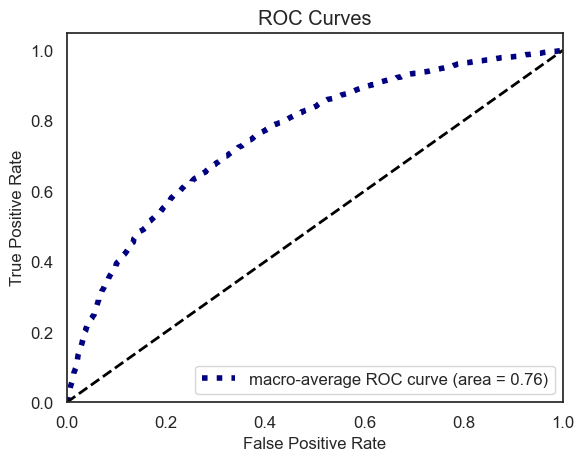

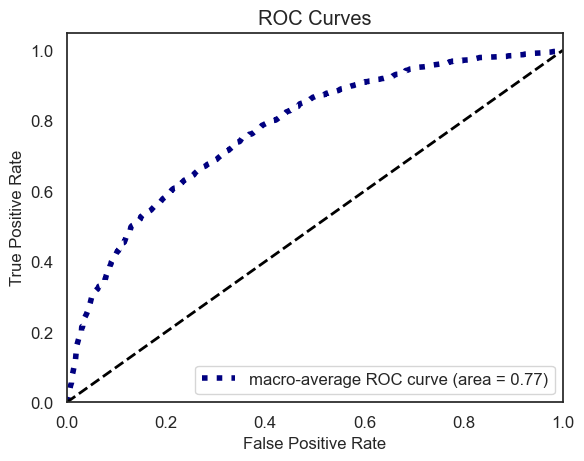

In [179]:
plot_roc_curve( y_true = Yt[tgt] , y_probas = mlog_reg.predict_proba( Xt[features] ) , curves = 'macro' )
plot_roc_curve( y_true = Yv[tgt] , y_probas = mlog_reg.predict_proba( Xv[features] ) , curves = 'macro' )

In [180]:
# es el mean accuracy
mlog_reg.score(Xt[features],Yt[tgt])

0.9476577840112202

In [181]:
# Realizamos la evaluación de nuestro modelo:
print('Entrenamiento: \n')
predictions_t = mlog_reg.predict(Xt[features])
print(classification_report(Yt_tgt, predictions_t))
print('Matriz: \n')
print(confusion_matrix(Yt_tgt, predictions_t))
print('Validación: \n')
predictions_v = mlog_reg.predict(Xv[features])
print(classification_report(Yv_tgt, predictions_v))
print('Matriz: \n')
print(confusion_matrix(Yv_tgt, predictions_v))

Entrenamiento: 

              precision    recall  f1-score   support

           0       0.95      1.00      0.97     16892
           1       0.00      0.00      0.00       933

    accuracy                           0.95     17825
   macro avg       0.47      0.50      0.49     17825
weighted avg       0.90      0.95      0.92     17825

Matriz: 

[[16892     0]
 [  933     0]]
Validación: 

              precision    recall  f1-score   support

           0       0.95      1.00      0.97      7237
           1       0.00      0.00      0.00       403

    accuracy                           0.95      7640
   macro avg       0.47      0.50      0.49      7640
weighted avg       0.90      0.95      0.92      7640

Matriz: 

[[7237    0]
 [ 403    0]]


c:\Users\Daniel\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Daniel\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Daniel\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

In [182]:
Xt2 = Xt[features]
Xv2 = Xv[features]

In [183]:
Xt2.shape, Xv2.shape, 

((17825, 4), (7640, 4))

In [184]:
mlog_reg.coef_

array([[-0.88248972, -0.49492044, -0.55238787, -0.26749206]])

In [185]:
mlog_reg.intercept_

array([-2.89446703])

In [186]:
coeficients = pd.DataFrame(zip(Xv[features].columns, np.transpose(mlog_reg.coef_)), columns=['features', 'coef']) 

In [187]:
coeficients['coef'] = coeficients['coef'].astype(float)
coeficients['features'] = coeficients['features'].astype(str)

In [188]:
coeficients.head()

,features,coef
0,w_z_annual_income_5,-0.882490
1,w_z_avg_bureau_score_6m_5,-0.494920
2,w_z_bureau_score_5,-0.552388
3,w_emp_length,-0.267492


In [189]:
coeficients.loc[coeficients.features == 'w_z_annual_income_5', 'coef']

0   -0.88249
Name: coef, dtype: float64

In [190]:
# valor de los coeficientes
v_w_z_annual_income_5 = coeficients.loc[coeficients.features == 'w_z_annual_income_5', 'coef']
v_w_z_avg_bureau_score_6m_5 = coeficients.loc[coeficients.features == 'w_z_avg_bureau_score_6m_5', 'coef']
v_w_z_bureau_score_5 = coeficients.loc[coeficients.features == 'w_z_bureau_score_5', 'coef']

In [191]:
Xt2['c_w_z_annual_income_5'] = pd.Series([v_w_z_annual_income_5.values for x in range(len(Xt2.index))])
Xt2['c_w_z_avg_bureau_score_6m_5'] = pd.Series([v_w_z_avg_bureau_score_6m_5.values for x in range(len(Xt2.index))])
Xt2['c_w_z_bureau_score_5'] = pd.Series([v_w_z_bureau_score_5.values for x in range(len(Xt2.index))])
#Xt2['c_w_z_annual_income_5'] =  v_w_z_annual_income_5 

C:\Users\Daniel\AppData\Local\Temp\ipykernel_12256\2187225543.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Xt2['c_w_z_annual_income_5'] = pd.Series([v_w_z_annual_income_5.values for x in range(len(Xt2.index))])
C:\Users\Daniel\AppData\Local\Temp\ipykernel_12256\2187225543.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Xt2['c_w_z_avg_bureau_score_6m_5'] = pd.Series([v_w_z_avg_bureau_score_6m_5.values for x in range(len(Xt2.index))])
C:\Users\Daniel\AppData\Local\Temp\ipykernel_12256\2187225543.py

In [192]:
Xt2['c_w_z_annual_income_5'] = Xt2['c_w_z_annual_income_5'].astype(float)
Xt2['c_w_z_avg_bureau_score_6m_5'] = Xt2['c_w_z_avg_bureau_score_6m_5'].astype(float)
Xt2['c_w_z_bureau_score_5'] = Xt2['c_w_z_bureau_score_5'].astype(float)

C:\Users\Daniel\AppData\Local\Temp\ipykernel_12256\4191208612.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Xt2['c_w_z_annual_income_5'] = Xt2['c_w_z_annual_income_5'].astype(float)
C:\Users\Daniel\AppData\Local\Temp\ipykernel_12256\4191208612.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Xt2['c_w_z_avg_bureau_score_6m_5'] = Xt2['c_w_z_avg_bureau_score_6m_5'].astype(float)
C:\Users\Daniel\AppData\Local\Temp\ipykernel_12256\4191208612.py:3: SettingWithCopyWarning: 
A value is trying to be set on 

In [130]:
# coeficients.pivot(columns ='features' ,values = 'coef')

In [193]:
Xt2.columns

Index(['w_z_annual_income_5', 'w_z_avg_bureau_score_6m_5',
       'w_z_bureau_score_5', 'w_emp_length', 'c_w_z_annual_income_5',
       'c_w_z_avg_bureau_score_6m_5', 'c_w_z_bureau_score_5'],
      dtype='object')

#### Función para calculo de probabilidad

In [94]:
#def logit2prob(mlog_reg,x):
#  log_odds = mlog_reg.coef_ * x + mlog_reg.intercept_
#  odds = np.exp(log_odds)
#  probability = odds / (1 + odds)
#  return(probability)

In [106]:
Xt2['log_odds'] = Xt2['w_z_annual_income_5'] * Xt2['c_w_z_annual_income_5'] + \
    Xt2['w_z_avg_bureau_score_6m_5'] * Xt2['c_w_z_avg_bureau_score_6m_5'] +\
        Xt2['w_z_bureau_score_5'] * Xt2['c_w_z_bureau_score_5'] + mlog_reg.intercept_

C:\Users\Daniel\AppData\Local\Temp\ipykernel_12256\3631049735.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Xt2['log_odds'] = Xt2['w_z_annual_income_5'] * Xt2['c_w_z_annual_income_5'] + \


In [107]:
Xt2['odds'] = np.exp(Xt2['log_odds'])

C:\Users\Daniel\AppData\Local\Temp\ipykernel_12256\495947559.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Xt2['odds'] = np.exp(Xt2['log_odds'])


In [108]:
#calculo de probabilidad , es igual al predict proba para el evento 1
Xt2['probability'] = Xt2['odds'] / (1 + Xt2['odds'])

C:\Users\Daniel\AppData\Local\Temp\ipykernel_12256\2720204572.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Xt2['probability'] = Xt2['odds'] / (1 + Xt2['odds'])


#### Función para el score

In [109]:
#New scale with anchor set at 660 points and log-odds doubling each 40 points and 72:1 odds ratio.
def scaled_score(logit,odds,offset = 500,pdo = 20):
    b = pdo/np.log(2)
    a = offset - b* np.log(odds)
    
    return round(a + b*(np.log((1 - logit)/logit)))

In [110]:
Xt2['score'] = scaled_score(Xt2['probability'],odds = 72,offset = 660,pdo = 40)

C:\Users\Daniel\AppData\Local\Temp\ipykernel_12256\1861026429.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Xt2['score'] = scaled_score(Xt2['probability'],odds = 72,offset = 660,pdo = 40)


In [111]:
features

['w_z_annual_income_5', 'w_z_avg_bureau_score_6m_5', 'w_z_bureau_score_5']

In [114]:
pd.DataFrame(mlog_reg.predict_proba(Xt2[features]))

,0,1
0,0.920032,0.079968
1,0.982317,0.017683
2,0.956252,0.043748
3,0.916178,0.083822
4,0.990364,0.009636
...,...,...
17820,0.977765,0.022235
17821,0.857492,0.142508
17822,0.986579,0.013421
17823,0.987864,0.012136


In [115]:
# elegimos el 1 porque estamos evaluando el evento de incumplimiento
Xt2['PD'] = mlog_reg.predict_proba(Xt2[features])[:,1]

C:\Users\Daniel\AppData\Local\Temp\ipykernel_12256\3450652055.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Xt2['PD'] = mlog_reg.predict_proba(Xt2[features])[:,1]


In [119]:
Xt2.head()

,w_z_annual_income_5,w_z_avg_bureau_score_6m_5,w_z_bureau_score_5,c_w_z_annual_income_5,c_w_z_avg_bureau_score_6m_5,c_w_z_bureau_score_5,log_odds,odds,probability,score,PD
0,-0.937919,0.411542,0.455421,-1.010963,-0.529734,-0.528769,-2.442777,0.086919,0.079968,554.0,0.079968
1,0.150212,0.866056,0.897396,-1.010963,-0.529734,-0.528769,-4.017311,0.018001,0.017683,645.0,0.017683
2,-0.937919,1.067878,1.011637,-1.010963,-0.529734,-0.528769,-3.084570,0.045750,0.043748,591.0,0.043748
3,0.427275,-0.922742,-0.914940,-1.010963,-0.529734,-0.528769,-2.391518,0.091491,0.083822,551.0,0.083822
4,0.758766,0.866056,0.897396,-1.010963,-0.529734,-0.528769,-4.632537,0.009730,0.009636,681.0,0.009636


In [121]:
Xt2.to_csv('Xt2.csv')

<Axes: >

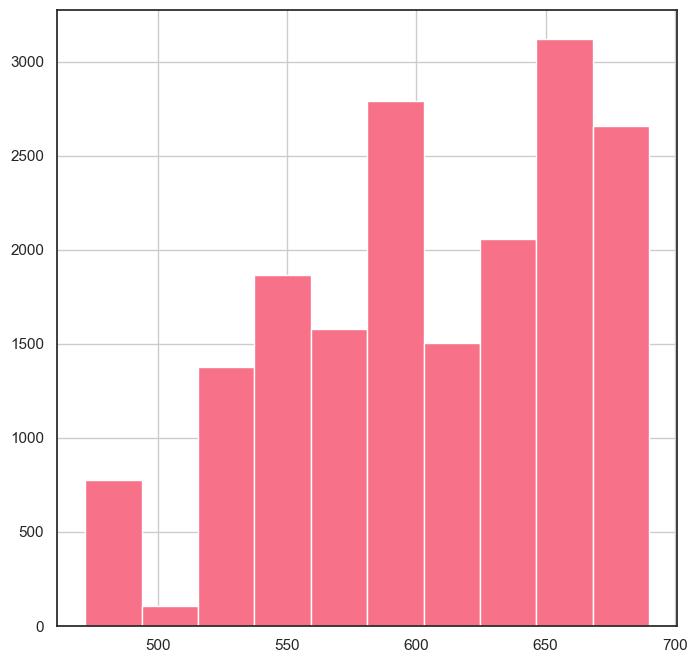

In [124]:
Xt2['score'].hist(figsize = (8,8))

In [152]:
# leer este papaer PD CON REGRESION LOGISTICA
# https://medium.com/@polanitzer/logistic-regression-in-python-predict-the-probability-of-default-of-an-individual-8a0091da3775

#### 5.1 Identificación de mejores variables predictivas

In [ ]:
iv_df_con.loc[(iv_df_con['rankeo'] == 3) | (iv_df_con['rankeo'] == 4)].reset_index(drop=True)

In [ ]:
iv_df_con['id'] = iv_df_con.apply(lambda x: 0 if x['rankeo'] < 3 or x['rankeo'] == 5 else 1, axis = 1)
iv_df_con

In [ ]:
iv_df_cat = iv_df_cat.loc[(iv_df_cat['rankeo'] == 3) | (iv_df_cat['rankeo'] == 4)].reset_index(drop = True)
iv_df_cat['raiz'] = iv_df_cat['Variable'].map( lambda x: '_'.join(x.split('_')[1:2] ) )
iv_df_cat = iv_df_cat.sort_values(by = ['raiz','IV'],ascending = [1,0]).reset_index(drop = True)
iv_df_cat['id'] = iv_df_cat.groupby('raiz').cumcount() + 1
iv_df_cat

In [ ]:
iv_df_con2 = iv_df_con.loc[iv_df_con.id == 1]
iv_df_con2

In [ ]:
iv_df_cat2 = iv_df_cat.loc[iv_df_cat.id == 1]
iv_df_cat2

#### 5.2 Mejores variables predictivas

In [ ]:
best_var_con = iv_df_con2['Variable'].tolist()
best_var_cat = iv_df_cat2['Variable'].tolist()
best_var = best_var_con + best_var_cat 
len(best_var) , best_var

#### 5.3 Segunda partición de los datos tomando en cuenta la mejores variables predictivas

In [ ]:
Xt_final = Xt[best_var].copy()
Xv_final = Xv[best_var].copy()

In [ ]:
Xt_final.shape, Xv_final.shape, Yt.shape[0], Yv.shape[0]

In [ ]:
Yt.head()

In [ ]:
Xt_final.info()

#### 6.0 Transformación WOE

#### 6.1 Codificación / Diccionario / Mapa WoE

In [ ]:
binning_process = BinningProcess(best_var)

In [ ]:
# replacing values of variables with woe
Xt_woe = binning_process.fit_transform(Xt_final,Yt)
Xv_woe = binning_process.fit_transform(Xv_final,Yv)

In [ ]:
#def codificacion_woe(df, v, tgt):
#    aux = df.pivot_table( index=v,
#                          columns=tgt,
#                          values=um[0],
#                          aggfunc='count',
#                          fill_value=0)

#    aux[list( range(2) )] = aux / aux.apply(np.sum)

#    aux['w'] = np.log( aux[0] / aux[1] )

#    aux.drop(range(2) , axis=1 , inplace=True )

#    aux = aux.to_dict()['w']
    
#    return v, aux

In [ ]:
mapa_woe = list( map(  lambda v: codificacion_woe( Xt , v , tgt  ) , best_var  ) )

In [ ]:
for v, mapa in mapa_woe:
    Xt[f'w_{v}'] = Xt[v].replace(mapa)
    Xv[f'w_{v}'] = Xv[v].replace(mapa)

In [ ]:
print(Xt.shape, Xv.shape, Yt.shape[0], Yv.shape[0])

In [ ]:
var_woe = Xt.filter(like='w_').columns.tolist()
var_woe

In [ ]:
Xt[var_woe].corr()

In [ ]:
# w_d_avg_bureau_score_6m_2 sale de la lista de variables debido a la alta correlacion con la variable
# w_d_avg_bureau_score_2 
del var_woe[7]
var_woe

In [ ]:
# se encontraron dos valores con valor infinito, se eliminaron de 
pd.set_option('display.max_columns',None)

Xt.loc[Xt.loc[:, 'w_num_ccj'] == np.inf]

In [ ]:
tad1 = Xt[um + var_woe].merge(Yt , on = um , how='inner')

In [ ]:
tad1.head()

#### Modelo

#### Entrenamiento

In [ ]:
tad1 = Xt[um + var_woe].merge(Yt , on = um , how='inner')

In [ ]:
m_reg_log = LogisticRegression()

In [ ]:
m_reg_log.fit( Xt[var_woe] , Yt[tgt] )

In [ ]:
m_reg_log.intercept_

In [ ]:
m_reg_log.coef_

In [ ]:
Xv.loc[Xv.loc[:, 'w_num_ccj'] == np.inf]

In [ ]:
Yv.loc[Yv.loc[:, 'id'] == 2610320]

In [ ]:
Yv.drop(Yv[Yv['id'] == 2610320].index, inplace = True)
Xv.drop(Xv[Xv['id'] == 2610320].index, inplace = True)

In [ ]:
pd.DataFrame(m_reg_log.predict_proba(Xv[var_woe]))

In [ ]:
pd.DataFrame(m_reg_log.predict(Xv[var_woe])).value_counts()

In [ ]:
Yv[tgt].value_counts()

In [ ]:
rest_v = m_reg_log.predict(Xv[var_woe])

In [ ]:
unique , counts = np.unique( rest_v , return_counts=True )

In [ ]:
dict(zip( unique , counts  ))

#### Evaluación

In [ ]:
from scikitplot.metrics import plot_roc_curve

In [ ]:
plot_roc_curve( y_true = Yt[tgt] , y_probas = m_reg_log.predict_proba( Xt[var_woe] ) , curves = 'macro' )
plot_roc_curve( y_true = Yv[tgt] , y_probas = m_reg_log.predict_proba( Xv[var_woe] ) , curves = 'macro' )

In [ ]:
from sklearn.metrics import roc_auc_score,accuracy_score,confusion_matrix

In [ ]:
def metricas(model,Xt,Xv,yt,yv):
    print(' Métricas para modelo de clasificación: \n')

    print(' Valor ROC train : %.3f'   %roc_auc_score( y_score = model.predict_proba(Xt)[:,1] , y_true = yt  )   )

    print(' Valor ROC validate : %.3f'   %roc_auc_score( y_score = model.predict_proba(Xv)[:,1] , y_true = yv  )   )

    print(' Valor ACC : %.3f\n' %accuracy_score( y_pred = model.predict(Xv) , y_true = yv) )

    print(' Matriz de confusión: ', '\n', confusion_matrix(y_pred = model.predict(Xv) , y_true = yv ) )

In [ ]:
metricas( m_reg_log,Xt[var_woe] ,Xv[var_woe], Yt[tgt], Yv[tgt])

#### Transformación Scoring

In [ ]:
betas = m_reg_log.coef_[0].tolist()
beta0 = m_reg_log.intercept_[0]

In [ ]:
betas , beta0

In [ ]:
n = len(betas)
n

In [ ]:
for v, beta in zip( var_woe , betas ):
    print(v, beta)
    
    Xt[f'p_{v}'] = np.ceil( (-Xt[v] * beta + beta0/ n ) * factor + offset / n )
    Xv[f'p_{v}'] = np.ceil( (-Xv[v] * beta + beta0/ n ) * factor + offset / n )

In [ ]:
Xt.head(1)

In [ ]:
var_puntos = [c for c in Xv.columns.tolist() if c[:2] == 'p_']
var_puntos

In [ ]:
Xt['score'] = Xt[var_puntos].sum(axis=1)
Xv['score'] = Xv[var_puntos].sum(axis=1)

In [ ]:
import seaborn as sns

In [ ]:
sns.distplot(Xt['score'], hist = True)
sns.distplot(Xv['score'], hist = True)

In [ ]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import PrecisionRecallDisplay

In [ ]:
# y_pred_prob = rest_v[:,1]
rest_v

In [ ]:
precision, recall, threshold = precision_recall_curve(Yv[tgt], rest_v)
prd = PrecisionRecallDisplay(precision, recall)
prd.plot()
#Yv[tgt]